# Deep Learning LSTM Prototype

## Imports

In [51]:
#standard imports
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

#tensorflow imports for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras import layers
from keras.constraints import maxnorm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



#sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

#copy for recursive
from copy import deepcopy

## Read Clean/Prepare Data

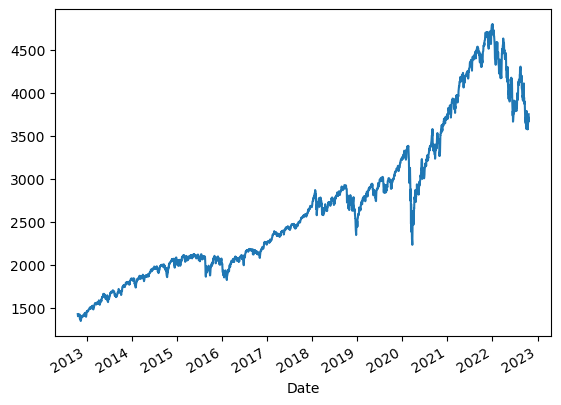

In [52]:
#read data in
df = pd.read_csv('sp500_index.csv')

#function to change string dates to datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

#apply str_to_datetime
df['Date'] = df['Date'].apply(str_to_datetime)

#set index
df.set_index('Date', inplace=True)

#plot whole dataset
df['S&P500'].plot()
plt.show()

#minmax scaler
scaler=MinMaxScaler(feature_range=(0,1))
scaledclose=scaler.fit_transform(np.array(df).reshape(-1,1))
df['Close'] = scaledclose
df_new = df[['Close']]

## Defining Functions

In [60]:
#Creating windowed dataframes
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)

    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
  
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
    
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
        if last_time:
            break
    
        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

#plotting train, val, and test data
def plot_train_val_test(dates, X, y):
    q_80 = int(len(dates) * .8)
    q_90 = int(len(dates) * .9)

    dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

    dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

    plt.plot(dates_train, y_train)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, y_test)

    plt.legend(['Train', 'Validation', 'Test'])
    plt.show()
    return dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test

#grid model for grid_search
def define_grid_model(learning_rate=0.001, neurons=10, dropout_rate=0.2, activation='relu'):
    model = Sequential([layers.Input((5, 1)),
                        layers.LSTM(neurons),
                        layers.Dense(32, activation=activation),
                        layers.Dropout(dropout_rate),
                        layers.Dense(32, activation=activation),
                        layers.Dense(1)])
    
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mean_absolute_error'])
    return model

#gridsearchcv to find best params
def grid_search(X_train, y_train):
    model = KerasClassifier(build_fn=define_grid_model, verbose=1)

    learning_rate = [0.001, 0.01]
    neurons = [32, 64]
    dropout_rate=[0, 0.1, 0.2]
    activation = ['relu', 'sigmoid']
    
    
    param_grid = dict(learning_rate=learning_rate, neurons=neurons, dropout_rate=dropout_rate, activation=activation)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
    grid_result = grid.fit(X_train, y_train, epochs=100)
    
    learning_rate = grid_result.best_params_['learning_rate']
    activation = grid_result.best_params_['activation']
    neurons = grid_result.best_params_['neurons']
    dropout_rate = grid_result.best_params_['dropout_rate']
    
    return learning_rate, neurons, dropout_rate, activation

#Training model on best params
def train_model(X_train, y_train, X_val, y_val, dates_val, X_test, y_test, dates_test, learning_rate, neurons, activation, dropout_rate):
    model = Sequential([layers.Input((X_train.shape[1], 1)),
                        layers.LSTM(neurons),
                        layers.Dense(32, activation=activation),
                        layers.Dropout(dropout_rate),
                        layers.Dense(32, activation=activation),
                        layers.Dense(1)])
    
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)
    
    recursive_predictions = []
    recursive_dates = np.concatenate([dates_val, dates_test])
    last_window = deepcopy(X_train[-1])
    for target_date in recursive_dates:
        next_prediction = model.predict(np.array([last_window])).flatten()
        recursive_predictions.append(next_prediction)
        for i in range(len(last_window)):
            if i == (len(last_window)-1):
                last_window[i] = next_prediction
            else:
                last_window[i] = last_window[i+1]
    return train_predictions, val_predictions, test_predictions, recursive_predictions

#function to plot various graphs
def plot_prediction_graphs(dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test, train_predictions, val_predictions, test_predictions, recursive_predictions):
    y_train = y_train.reshape(-1, 1)
    train_predictions=scaler.inverse_transform(train_predictions)
    y_train = scaler.inverse_transform(y_train)
    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.legend(['Training Predictions', 'Training Observations'])
    plt.show()

    y_val = y_val.reshape(-1, 1)
    val_predictions=scaler.inverse_transform(val_predictions)
    y_val = scaler.inverse_transform(y_val)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.legend(['Validation Predictions', 'Validation Observations'])
    plt.show()

    y_test = y_test.reshape(-1, 1)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test = scaler.inverse_transform(y_test)

    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Testing Predictions', 'Testing Observations'])
    plt.show()

    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations'])
    plt.show()
    
    recursive_dates = np.concatenate([dates_val, dates_test])
    recursive_predictions = scaler.inverse_transform(recursive_predictions)
    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.plot(recursive_dates, recursive_predictions)
    plt.legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations',
                'Recursive Predictions'])
    plt.show()
    
    recursive_test = np.concatenate((np.array(y_val), np.array(y_test)))
   
    print(f"Mean Absolute Error for Training Data is: {mean_absolute_error(y_train, train_predictions)}")
    print(f"Mean Absolute Error for Validation Data is: {mean_absolute_error(y_val, val_predictions)}")
    print(f"Mean Absolute Error for Test Data is: {mean_absolute_error(y_test, test_predictions)}")
    print(f"Mean Absolute Error for Recursive Data is: {mean_absolute_error(recursive_test, recursive_predictions)}")

#function to run the whole script
def mle_analysis(df):
    windowed_df = df_to_windowed_df(df, '2021-03-25', '2022-03-23', n=5)
    dates, X, y = windowed_df_to_date_X_y(windowed_df)
    dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test = plot_train_val_test(dates, X, y)
    learning_rate, neurons, dropout_rate, activation = grid_search(X_train, y_train)
    train_predictions, val_predictions, test_predictions, recursive_predictions = train_model(X_train, y_train, X_val, y_val, dates_val, X_test, y_test, dates_test, learning_rate, neurons, activation, dropout_rate)
    plot_prediction_graphs(dates_train, X_train, y_train, dates_val, X_val, y_val, dates_test, X_test, y_test, train_predictions, val_predictions, test_predictions, recursive_predictions)

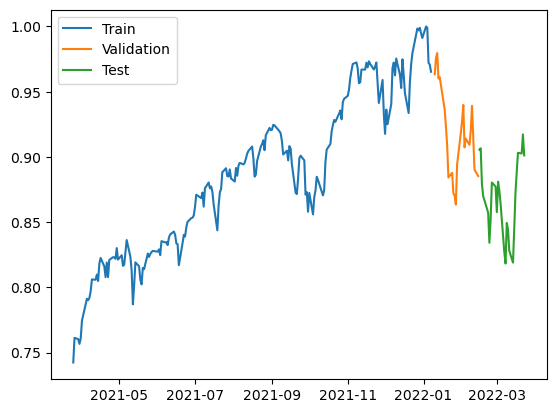

/var/folders/b6/4qc_2zbx4bg37ybn_70yv7xc0000gn/T/ipykernel_857/819028858.py:96: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=define_grid_model, verbose=1)
2023-06-04 22:04:20.425034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 22:04:20.424989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNN

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
5/5 [==============================] - 4s 7ms/step - loss: 5899.5249 - mean_absolute_error: 66.3646
Epoch 2/100
5/5 [==============================] - 4s 8ms/step - loss: 5924.9995 - mean_absolute_error: 66.5470
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 5913.5825 - mean_absolute_error: 66.4636
Epoch 3/100
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 5904.8462 - mean_absolute_error: 66.4013
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 5865.1621 - mean_absolute_error: 66.1150
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 5895.9336 - mean_absolute_error: 66.3353
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 5897.3115 - mean_absolute_error: 66.3455
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 5839.5034 - mean_absolute_error: 65.9330
Epoch 4/100
Epoch 5/100
5/5 [==========================

5/5 [==============================] - 0s 10ms/step - loss: 1835.0696 - mean_absolute_error: 35.9946
Epoch 16/100
Epoch 19/100
5/5 [==============================] - 0s 7ms/step - loss: 2645.2144 - mean_absolute_error: 41.9964
Epoch 20/100
5/5 [==============================] - 0s 11ms/step - loss: 2724.2988 - mean_absolute_error: 42.6818
Epoch 17/100
Epoch 21/100
5/5 [==============================] - 0s 7ms/step - loss: 2393.8608 - mean_absolute_error: 40.2596
Epoch 21/100
5/5 [==============================] - 0s 9ms/step - loss: 2258.4128 - mean_absolute_error: 39.1263
Epoch 22/100
5/5 [==============================] - 0s 7ms/step - loss: 1578.7219 - mean_absolute_error: 34.1536
Epoch 18/100
5/5 [==============================] - 0s 8ms/step - loss: 1526.4746 - mean_absolute_error: 33.6573
Epoch 23/100
Epoch 22/100
5/5 [==============================] - 0s 8ms/step - loss: 1940.1460 - mean_absolute_error: 36.8235
Epoch 19/100
5/5 [==============================] - 0s 9ms/step - lo

5/5 [==============================] - 0s 6ms/step - loss: 1494.1160 - mean_absolute_error: 33.4754
Epoch 58/100
Epoch 56/100
5/5 [==============================] - 0s 8ms/step - loss: 1386.7439 - mean_absolute_error: 32.1443
Epoch 57/100
Epoch 59/100
Epoch 59/100
Epoch 55/100
5/5 [==============================] - 0s 21ms/step - loss: 1487.1152 - mean_absolute_error: 33.3929
Epoch 60/100
Epoch 56/100
5/5 [==============================] - 0s 11ms/step - loss: 1490.7886 - mean_absolute_error: 33.4410
Epoch 61/100
Epoch 59/100
5/5 [==============================] - 0s 6ms/step - loss: 1485.0697 - mean_absolute_error: 33.3391
Epoch 61/100
Epoch 57/100
5/5 [==============================] - 0s 7ms/step - loss: 1333.9348 - mean_absolute_error: 31.4043
Epoch 62/100
5/5 [==============================] - 0s 7ms/step - loss: 1482.2629 - mean_absolute_error: 33.3099
Epoch 58/100
5/5 [==============================] - 0s 8ms/step - loss: 1494.5573 - mean_absolute_error: 33.4745
Epoch 60/100
5/5

5/5 [==============================] - 0s 9ms/step - loss: 1505.6041 - mean_absolute_error: 33.5422
Epoch 61/100
5/5 [==============================] - 0s 7ms/step - loss: 1280.2878 - mean_absolute_error: 30.7414
Epoch 65/100
Epoch 65/100
5/5 [==============================] - 0s 7ms/step - loss: 1497.8253 - mean_absolute_error: 33.4923
Epoch 63/100
Epoch 66/100
5/5 [==============================] - 0s 9ms/step - loss: 1250.8037 - mean_absolute_error: 30.3957
Epoch 66/100
5/5 [==============================] - 0s 8ms/step - loss: 1494.6322 - mean_absolute_error: 33.4761
Epoch 64/100
5/5 [==============================] - 0s 6ms/step - loss: 1496.0731 - mean_absolute_error: 33.4916
Epoch 67/100
Epoch 67/100
Epoch 63/100
Epoch 65/100
5/5 [==============================] - 0s 6ms/step - loss: 1491.0682 - mean_absolute_error: 33.4286
Epoch 68/100
5/5 [==============================] - 0s 8ms/step - loss: 1471.6337 - mean_absolute_error: 33.2129
Epoch 68/100
5/5 [==========================

5/5 [==============================] - 0s 7ms/step - loss: 1298.3080 - mean_absolute_error: 31.2342
Epoch 92/100
5/5 [==============================] - 0s 10ms/step - loss: 568.5501 - mean_absolute_error: 19.1314
Epoch 96/100
5/5 [==============================] - 0s 7ms/step - loss: 1291.7549 - mean_absolute_error: 31.0382
Epoch 97/100
Epoch 93/100
5/5 [==============================] - 0s 9ms/step - loss: 531.8026 - mean_absolute_error: 18.9153
Epoch 97/100
5/5 [==============================] - 0s 10ms/step - loss: 1485.8153 - mean_absolute_error: 33.3812
Epoch 95/100
Epoch 98/100
5/5 [==============================] - 0s 10ms/step - loss: 1262.3229 - mean_absolute_error: 30.6065
Epoch 94/100
5/5 [==============================] - 0s 18ms/step - loss: 1489.4629 - mean_absolute_error: 33.4110
Epoch 96/100
5/5 [==============================] - 0s 24ms/step - loss: 511.0697 - mean_absolute_error: 18.6790
Epoch 98/100
5/5 [==============================] - 0s 16ms/step - loss: 1271.530

3/3 [==============================] - 1s 3ms/step - loss: 4351.6343 - mean_absolute_error: 65.9662


/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method

Epoch 1/100
Epoch 1/100
Epoch 1/100
5/5 [==============================] - 3s 6ms/step - loss: 5919.0054 - mean_absolute_error: 66.5034
Epoch 2/100
5/5 [==============================] - 0s 5ms/step - loss: 5903.0371 - mean_absolute_error: 66.3867
Epoch 3/100
5/5 [==============================] - 0s 5ms/step - loss: 5888.0059 - mean_absolute_error: 66.2768
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 5867.9102 - mean_absolute_error: 66.1317
Epoch 5/100
5/5 [==============================] - 3s 5ms/step - loss: 5833.6318 - mean_absolute_error: 65.8254
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 5840.3940 - mean_absolute_error: 65.9277
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 2537.0161 - mean_absolute_error: 40.6167
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 5797.9370 - mean_absolute_error: 65.6206
Epoch 7/100
5/5 [==============================] - 0s 8ms/step - loss: 1889.7003

/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/keras/wrappers/scikit_learn.py", line 323, in score
    raise ValueError('The model is not configured to compute accuracy. '
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method

5/5 [==============================] - 0s 6ms/step - loss: 1718.6294 - mean_absolute_error: 35.3873
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 5893.8608 - mean_absolute_error: 66.3218
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 1610.2412 - mean_absolute_error: 34.5261
Epoch 9/100
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 5869.6245 - mean_absolute_error: 66.1497
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 5839.6235 - mean_absolute_error: 65.9355
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 1592.0321 - mean_absolute_error: 34.1097
Epoch 8/100
5/5 [==============================] - 0s 10ms/step - loss: 5419.4180 - mean_absolute_error: 62.8297
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 5800.6587 - mean_absolute_error: 65.6515
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 1513.3173 - mean_absolute_error

.

  warnings.warn(


5/5 [==============================] - 0s 14ms/step - loss: 1507.8672 - mean_absolute_error: 33.7177
Epoch 83/100
Epoch 85/100
5/5 [==============================] - 0s 8ms/step - loss: 1482.3014 - mean_absolute_error: 33.2887
Epoch 86/100
Epoch 84/100
5/5 [==============================] - 0s 6ms/step - loss: 1477.7864 - mean_absolute_error: 33.2299
Epoch 85/100
Epoch 87/100
5/5 [==============================] - 0s 10ms/step - loss: 938.2026 - mean_absolute_error: 25.9739
Epoch 80/100
5/5 [==============================] - 0s 8ms/step - loss: 1467.7584 - mean_absolute_error: 33.1346
Epoch 88/100
Epoch 86/100
5/5 [==============================] - 0s 7ms/step - loss: 904.1534 - mean_absolute_error: 25.0640
Epoch 81/100
5/5 [==============================] - 0s 7ms/step - loss: 1461.9153 - mean_absolute_error: 33.1004
Epoch 87/100
Epoch 89/100
5/5 [==============================] - 0s 7ms/step - loss: 891.5107 - mean_absolute_error: 25.3640
Epoch 82/100
5/5 [===========================

3/3 [==============================] - 1s 3ms/step - loss: 77.7492 - mean_absolute_error: 7.3490
Epoch 1/100
Epoch 1/100
Epoch 1/100
5/5 [==============================] - 3s 6ms/step - loss: 5879.8755 - mean_absolute_error: 66.2014
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 5499.4854 - mean_absolute_error: 63.5042
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 4155.4863 - mean_absolute_error: 53.4979
Epoch 4/100
5/5 [==============================] - 0s 6ms/step - loss: 2254.6008 - mean_absolute_error: 39.1954
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 1554.9835 - mean_absolute_error: 33.9440
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 1782.1208 - mean_absolute_error: 35.7562
Epoch 7/100
5/5 [==============================] - 0s 6ms/step - loss: 1485.8929 - mean_absolute_error: 33.2997
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 1646.3025 - mean_absolut

Epoch 57/100
Epoch 38/100
5/5 [==============================] - 0s 7ms/step - loss: 1506.5060 - mean_absolute_error: 33.6077
Epoch 57/100
5/5 [==============================] - 0s 7ms/step - loss: 1516.0681 - mean_absolute_error: 33.7173
Epoch 39/100
5/5 [==============================] - 0s 9ms/step - loss: 1537.4426 - mean_absolute_error: 33.7215
Epoch 58/100
5/5 [==============================] - 0s 8ms/step - loss: 1510.4835 - mean_absolute_error: 33.7024
Epoch 40/100
5/5 [==============================] - 0s 8ms/step - loss: 1567.2885 - mean_absolute_error: 34.0643
Epoch 59/100
5/5 [==============================] - 0s 10ms/step - loss: 1530.8011 - mean_absolute_error: 33.8194
Epoch 41/100
5/5 [==============================] - 0s 10ms/step - loss: 1594.3513 - mean_absolute_error: 34.5098
Epoch 60/100
5/5 [==============================] - 0s 15ms/step - loss: 1495.2507 - mean_absolute_error: 33.4464
Epoch 60/100
5/5 [==============================] - 0s 15ms/step - loss: 1532.34

Epoch 1/100
3/3 [==============================] - 1s 3ms/step - loss: 105.9559 - mean_absolute_error: 9.5993
Epoch 1/100
Epoch 1/100
Epoch 1/100
5/5 [==============================] - 4s 7ms/step - loss: 5873.0527 - mean_absolute_error: 66.1737
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 5107.6030 - mean_absolute_error: 60.8207
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 2995.4065 - mean_absolute_error: 44.1871
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 1620.9677 - mean_absolute_error: 34.5996
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 1855.6747 - mean_absolute_error: 36.1327
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 1559.2725 - mean_absolute_error: 34.0248
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 1749.7216 - mean_absolute_error: 35.4363
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 1614.5497 -

5/5 [==============================] - 0s 8ms/step - loss: 1886.4441 - mean_absolute_error: 36.7275
Epoch 23/100
5/5 [==============================] - 0s 9ms/step - loss: 1506.6488 - mean_absolute_error: 33.5962
Epoch 50/100
Epoch 23/100
5/5 [==============================] - 0s 7ms/step - loss: 2821.5283 - mean_absolute_error: 43.6021
Epoch 24/100
Epoch 51/100
5/5 [==============================] - 0s 8ms/step - loss: 1643.7562 - mean_absolute_error: 34.9825
Epoch 25/100
5/5 [==============================] - 0s 8ms/step - loss: 1529.3771 - mean_absolute_error: 33.8325
Epoch 52/100
5/5 [==============================] - 0s 11ms/step - loss: 1586.0229 - mean_absolute_error: 34.8175
Epoch 26/100
5/5 [==============================] - 0s 7ms/step - loss: 1503.7443 - mean_absolute_error: 33.5862
Epoch 53/100
5/5 [==============================] - 0s 8ms/step - loss: 2329.0432 - mean_absolute_error: 39.7906
Epoch 26/100
5/5 [==============================] - 0s 7ms/step - loss: 1594.1437 

5/5 [==============================] - 0s 10ms/step - loss: 1511.7427 - mean_absolute_error: 33.1923
Epoch 95/100
Epoch 41/100
5/5 [==============================] - 0s 7ms/step - loss: 1568.7833 - mean_absolute_error: 34.4471
Epoch 42/100
5/5 [==============================] - 0s 8ms/step - loss: 429.3790 - mean_absolute_error: 16.2894
Epoch 96/100
5/5 [==============================] - 0s 28ms/step - loss: 1597.6052 - mean_absolute_error: 34.6398
Epoch 94/100
5/5 [==============================] - 0s 7ms/step - loss: 1448.3112 - mean_absolute_error: 32.7448
Epoch 97/100
Epoch 43/100
5/5 [==============================] - 0s 8ms/step - loss: 1550.9332 - mean_absolute_error: 34.2539
Epoch 95/100
1/5 [=====>........................] - ETA: 0s - loss: 1529.6467 - mean_absolute_error: 32.2390Epoch 44/100
Epoch 98/100
5/5 [==============================] - 0s 9ms/step - loss: 1567.5066 - mean_absolute_error: 33.9477
Epoch 96/100
5/5 [==============================] - 0s 9ms/step - loss: 14

5/5 [==============================] - 0s 6ms/step - loss: 1267.9545 - mean_absolute_error: 30.9712
Epoch 94/100
5/5 [==============================] - 0s 6ms/step - loss: 1333.0708 - mean_absolute_error: 31.3121
Epoch 95/100
Epoch 1/100
5/5 [==============================] - 0s 6ms/step - loss: 1290.4214 - mean_absolute_error: 30.9172
Epoch 96/100
5/5 [==============================] - 0s 7ms/step - loss: 1216.0182 - mean_absolute_error: 29.6546
Epoch 97/100
5/5 [==============================] - 0s 6ms/step - loss: 1245.6497 - mean_absolute_error: 30.2869
Epoch 98/100
5/5 [==============================] - 0s 6ms/step - loss: 1146.9684 - mean_absolute_error: 29.0383
Epoch 99/100
5/5 [==============================] - 0s 6ms/step - loss: 1199.0002 - mean_absolute_error: 29.5525
Epoch 100/100
5/5 [==============================] - 0s 6ms/step - loss: 1201.6906 - mean_absolute_error: 29.9794
Epoch 1/100
Epoch 1/100
3/3 [==============================] - 1s 3ms/step - loss: 2650.5625 - m

5/5 [==============================] - 0s 9ms/step - loss: 1661.6436 - mean_absolute_error: 35.0992
Epoch 22/100
5/5 [==============================] - 0s 8ms/step - loss: 1537.0525 - mean_absolute_error: 33.5648
Epoch 25/100
5/5 [==============================] - 0s 9ms/step - loss: 1619.3033 - mean_absolute_error: 35.0976
Epoch 23/100
5/5 [==============================] - 0s 8ms/step - loss: 1559.0728 - mean_absolute_error: 33.7388
Epoch 26/100
5/5 [==============================] - 0s 8ms/step - loss: 1632.8453 - mean_absolute_error: 34.5733
Epoch 24/100
5/5 [==============================] - 0s 8ms/step - loss: 1512.2238 - mean_absolute_error: 33.4420
Epoch 27/100
5/5 [==============================] - 0s 9ms/step - loss: 1525.2762 - mean_absolute_error: 33.8569
Epoch 25/100
5/5 [==============================] - 0s 9ms/step - loss: 1499.6086 - mean_absolute_error: 33.4579
Epoch 28/100
5/5 [==============================] - 0s 7ms/step - loss: 1607.4242 - mean_absolute_error: 34.5

5/5 [==============================] - 0s 9ms/step - loss: 1461.0170 - mean_absolute_error: 32.6823
Epoch 40/100
Epoch 37/100
5/5 [==============================] - 0s 8ms/step - loss: 1526.7588 - mean_absolute_error: 33.5411
Epoch 38/100
5/5 [==============================] - 0s 8ms/step - loss: 1515.0631 - mean_absolute_error: 33.7530
Epoch 41/100
5/5 [==============================] - 0s 9ms/step - loss: 1601.8029 - mean_absolute_error: 34.5168
Epoch 38/100
5/5 [==============================] - 0s 8ms/step - loss: 1598.4423 - mean_absolute_error: 34.6313
Epoch 39/100
5/5 [==============================] - 0s 8ms/step - loss: 1454.7688 - mean_absolute_error: 32.7825
Epoch 42/100
5/5 [==============================] - 0s 8ms/step - loss: 1561.2687 - mean_absolute_error: 33.6694
Epoch 39/100
5/5 [==============================] - 0s 9ms/step - loss: 1499.8287 - mean_absolute_error: 33.6654
Epoch 40/100
5/5 [==============================] - 0s 7ms/step - loss: 1504.7711 - mean_absolut

5/5 [==============================] - 0s 8ms/step - loss: 1518.4203 - mean_absolute_error: 33.6071
Epoch 72/100
Epoch 75/100
5/5 [==============================] - 0s 8ms/step - loss: 1585.7175 - mean_absolute_error: 34.2156
Epoch 73/100
5/5 [==============================] - 0s 8ms/step - loss: 903.4038 - mean_absolute_error: 24.9415
Epoch 76/100
Epoch 73/100
5/5 [==============================] - 0s 9ms/step - loss: 1503.0625 - mean_absolute_error: 33.1290
Epoch 74/100
5/5 [==============================] - 0s 7ms/step - loss: 987.4664 - mean_absolute_error: 26.8156
Epoch 74/100
Epoch 77/100
5/5 [==============================] - 0s 8ms/step - loss: 1551.5758 - mean_absolute_error: 34.1698
Epoch 75/100
5/5 [==============================] - 0s 8ms/step - loss: 1042.4456 - mean_absolute_error: 26.6360
Epoch 75/100
5/5 [==============================] - 0s 9ms/step - loss: 1502.9766 - mean_absolute_error: 33.7078
Epoch 78/100
5/5 [==============================] - 0s 7ms/step - loss: 

5/5 [==============================] - 0s 8ms/step - loss: 1535.6345 - mean_absolute_error: 33.8686
Epoch 26/100
5/5 [==============================] - 0s 6ms/step - loss: 1561.4897 - mean_absolute_error: 34.2568
Epoch 27/100
5/5 [==============================] - 0s 6ms/step - loss: 1570.7546 - mean_absolute_error: 33.8738
Epoch 28/100
5/5 [==============================] - 0s 6ms/step - loss: 1557.9286 - mean_absolute_error: 33.9624
Epoch 29/100
5/5 [==============================] - 0s 6ms/step - loss: 1570.0956 - mean_absolute_error: 34.0929
Epoch 30/100
5/5 [==============================] - 0s 6ms/step - loss: 1564.0575 - mean_absolute_error: 33.8424
Epoch 31/100
5/5 [==============================] - 0s 7ms/step - loss: 1598.8087 - mean_absolute_error: 34.4364
Epoch 32/100
5/5 [==============================] - 0s 6ms/step - loss: 1536.9088 - mean_absolute_error: 33.6407
Epoch 33/100
5/5 [==============================] - 0s 7ms/step - loss: 1606.8811 - mean_absolute_error: 33.7

Epoch 52/100
5/5 [==============================] - 0s 7ms/step - loss: 1518.1478 - mean_absolute_error: 33.7362
Epoch 53/100
5/5 [==============================] - 0s 6ms/step - loss: 1519.1726 - mean_absolute_error: 33.5596
Epoch 54/100
5/5 [==============================] - 0s 6ms/step - loss: 1547.3857 - mean_absolute_error: 33.8963
Epoch 55/100
5/5 [==============================] - 0s 6ms/step - loss: 1593.3081 - mean_absolute_error: 34.3476
Epoch 56/100
5/5 [==============================] - 0s 6ms/step - loss: 1581.7365 - mean_absolute_error: 33.9581
Epoch 57/100
5/5 [==============================] - 0s 7ms/step - loss: 1516.6202 - mean_absolute_error: 33.5590
Epoch 58/100
5/5 [==============================] - 0s 6ms/step - loss: 1545.6735 - mean_absolute_error: 33.7918
Epoch 59/100
5/5 [==============================] - 0s 6ms/step - loss: 1609.5890 - mean_absolute_error: 34.6815
Epoch 60/100
5/5 [==============================] - 0s 7ms/step - loss: 1521.2262 - mean_absolut

3/3 [==============================] - 1s 3ms/step - loss: 5214.9854 - mean_absolute_error: 72.2145
Epoch 1/100
5/5 [==============================] - 4s 7ms/step - loss: 5881.2720 - mean_absolute_error: 66.2369
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 5459.2310 - mean_absolute_error: 63.0649
Epoch 3/100
5/5 [==============================] - 0s 6ms/step - loss: 3758.1514 - mean_absolute_error: 50.4783
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 1774.5281 - mean_absolute_error: 35.7366
Epoch 5/100
5/5 [==============================] - 0s 6ms/step - loss: 1925.6185 - mean_absolute_error: 36.8348
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 1626.1401 - mean_absolute_error: 34.9074
Epoch 7/100
5/5 [==============================] - 0s 9ms/step - loss: 1595.6737 - mean_absolute_error: 34.5903
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 1619.4819 - mean_absolute_error: 34.3985
Epoc

5/5 [==============================] - 0s 10ms/step - loss: 1576.8353 - meanlute_error: 29.3952_absolute_error: 34.2796
Epoch 54/100
5/5 [==============================] - 0s 8ms/step - loss: 1496.2208 - mean_absolute_error: 33.7003
Epoch 60/100
5/5 [==============================] - 0s 8ms/step - loss: 1585.2415 - mean_absolute_error: 34.0510
Epoch 70/100
5/5 [==============================] - 0s 10ms/step - loss: 1523.4014 - mean_absolute_error: 33.6692
Epoch 55/100
5/5 [==============================] - 0s 8ms/step - loss: 1532.1199 - mean_absolute_error: 33.6666
Epoch 61/100
Epoch 71/100
5/5 [==============================] - 0s 7ms/step - loss: 1492.5587 - mean_absolute_error: 33.5571
Epoch 56/100
5/5 [==============================] - 0s 7ms/step - loss: 1606.5480 - mean_absolute_error: 34.4153
Epoch 62/100
5/5 [==============================] - 0s 8ms/step - loss: 1592.4762 - mean_absolute_error: 33.9843
Epoch 72/100
5/5 [==============================] - 0s 9ms/step - loss: 158

Epoch 86/100
5/5 [==============================] - 0s 7ms/step - loss: 1325.4454 - mean_absolute_error: 31.0095
Epoch 95/100
5/5 [==============================] - 0s 8ms/step - loss: 1564.3738 - mean_absolute_error: 33.9912
Epoch 87/100
5/5 [==============================] - 0s 7ms/step - loss: 1195.1147 - mean_absolute_error: 29.2778
Epoch 96/100
5/5 [==============================] - 0s 7ms/step - loss: 1539.3263 - mean_absolute_error: 33.6899
Epoch 88/100
5/5 [==============================] - 0s 7ms/step - loss: 1222.3998 - mean_absolute_error: 28.9841
Epoch 97/100
5/5 [==============================] - 0s 9ms/step - loss: 1548.0078 - mean_absolute_error: 33.9705
Epoch 89/100
5/5 [==============================] - 0s 9ms/step - loss: 489.9117 - mean_absolute_error: 18.5671
Epoch 98/100
5/5 [==============================] - 0s 8ms/step - loss: 1551.2682 - mean_absolute_error: 33.8914
Epoch 90/100
5/5 [==============================] - 0s 7ms/step - loss: 480.6623 - mean_absolute_

5/5 [==============================] - 7s 9ms/step - loss: 5863.2300 - mean_absolute_error: 66.1000
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 5016.0293 - mean_absolute_error: 59.9718
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 2868.3306 - mean_absolute_error: 43.7153
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 1769.3481 - mean_absolute_error: 35.5711
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 1868.1202 - mean_absolute_error: 36.5512
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 1576.8357 - mean_absolute_error: 34.5248
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 1791.0010 - mean_absolute_error: 35.7921
Epoch 8/100
5/5 [==============================] - 0s 10ms/step - loss: 1592.4594 - mean_absolute_error: 33.8019
Epoch 9/100
5/5 [==============================] - 0s 12ms/step - loss: 1623.0825 - mean_absolute_error: 34.6400
Ep

5/5 [==============================] - 0s 8ms/step - loss: 1492.5750 - mean_absolute_error: 33.0140
Epoch 32/100
5/5 [==============================] - 0s 7ms/step - loss: 1562.0968 - mean_absolute_error: 34.5795
Epoch 33/100
5/5 [==============================] - 0s 7ms/step - loss: 1604.7399 - mean_absolute_error: 34.3219
Epoch 34/100
5/5 [==============================] - 0s 7ms/step - loss: 1631.7103 - mean_absolute_error: 35.0129
Epoch 35/100
5/5 [==============================] - 0s 8ms/step - loss: 1609.2272 - mean_absolute_error: 34.4521
Epoch 36/100
5/5 [==============================] - 0s 7ms/step - loss: 1659.7805 - mean_absolute_error: 34.8626
Epoch 37/100
5/5 [==============================] - 0s 8ms/step - loss: 1524.7601 - mean_absolute_error: 33.4112
Epoch 38/100
5/5 [==============================] - 0s 7ms/step - loss: 1589.2294 - mean_absolute_error: 34.1622
Epoch 39/100
5/5 [==============================] - 0s 7ms/step - loss: 1604.4698 - mean_absolute_error: 34.5

3/3 [==============================] - 1s 3ms/step - loss: 14.2774 - mean_absolute_error: 2.9763
Epoch 1/100
5/5 [==============================] - 5s 7ms/step - loss: 5872.1943 - mean_absolute_error: 66.1062
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 4891.5850 - mean_absolute_error: 58.8201
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 2606.9585 - mean_absolute_error: 42.0885
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 1697.4636 - mean_absolute_error: 34.4449
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 1776.6185 - mean_absolute_error: 35.2540
Epoch 6/100
5/5 [==============================] - 0s 9ms/step - loss: 1603.9889 - mean_absolute_error: 34.4670
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 1675.3534 - mean_absolute_error: 35.0901
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 1653.5535 - mean_absolute_error: 35.3478
Epoch 9

5/5 [==============================] - 0s 9ms/step - loss: 1546.3970 - mean_absolute_error: 33.4394
Epoch 26/100
5/5 [==============================] - 0s 8ms/step - loss: 1533.9244 - mean_absolute_error: 33.5033
Epoch 36/100
5/5 [==============================] - 0s 8ms/step - loss: 1628.5647 - mean_absolute_error: 34.4014
Epoch 27/100
5/5 [==============================] - 0s 8ms/step - loss: 1515.7491 - mean_absolute_error: 33.7034
Epoch 23/100
5/5 [==============================] - 0s 10ms/step - loss: 1540.3882 - mean_absolute_error: 33.7133
Epoch 37/100
5/5 [==============================] - 0s 8ms/step - loss: 1621.4929 - mean_absolute_error: 34.3718
Epoch 24/100
5/5 [==============================] - 0s 8ms/step - loss: 1534.8815 - mean_absolute_error: 33.6999
Epoch 38/100
Epoch 29/100
5/5 [==============================] - 0s 9ms/step - loss: 1509.9047 - mean_absolute_error: 32.8903
Epoch 25/100
5/5 [==============================] - 0s 8ms/step - loss: 1499.1495 - mean_absolu

5/5 [==============================] - 0s 7ms/step - loss: 227.8442 - mean_absolute_error: 11.4767
Epoch 99/100
5/5 [==============================] - 0s 7ms/step - loss: 354.2458 - mean_absolute_error: 15.0302
Epoch 100/100
5/5 [==============================] - 0s 7ms/step - loss: 350.2810 - mean_absolute_error: 14.7255


3/3 [==============================] - 1s 3ms/step - loss: 145.8545 - mean_absolute_error: 9.8572
Epoch 1/100
Epoch 1/100
5/5 [==============================] - 7s 6ms/step - loss: 5907.8687 - mean_absolute_error: 66.4235
Epoch 2/100
5/5 [==============================] - 0s 6ms/step - loss: 5892.5981 - mean_absolute_error: 66.3095
Epoch 3/100
5/5 [==============================] - 0s 7ms/step - loss: 5875.1592 - mean_absolute_error: 66.1840
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 5855.0220 - mean_absolute_error: 66.0400
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 5826.8423 - mean_absolute_error: 65.8274
Epoch 6/100
5/5 [==============================] - 0s 6ms/step - loss: 5791.5435 - mean_absolute_error: 65.5714
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 5744.2686 - mean_absolute_error: 65.2010
Epoch 8/100
5/5 [==============================] - 0s 6ms/step - loss: 5671.8599 - mean_absolute_error: 64

5/5 [==============================] - 0s 7ms/step - loss: 1472.0024 - mean_absolute_error: 32.4982
Epoch 75/100
5/5 [==============================] - 0s 7ms/step - loss: 1461.7604 - mean_absolute_error: 32.5396
Epoch 76/100
5/5 [==============================] - 0s 7ms/step - loss: 1362.2378 - mean_absolute_error: 31.5246
Epoch 77/100
5/5 [==============================] - 0s 7ms/step - loss: 1513.6155 - mean_absolute_error: 33.0867
Epoch 78/100
5/5 [==============================] - 0s 7ms/step - loss: 1454.8033 - mean_absolute_error: 32.6963
Epoch 79/100
5/5 [==============================] - 0s 7ms/step - loss: 1378.3628 - mean_absolute_error: 31.8714
Epoch 80/100
5/5 [==============================] - 0s 7ms/step - loss: 1491.5356 - mean_absolute_error: 33.0679
Epoch 81/100
5/5 [==============================] - 0s 7ms/step - loss: 1459.5809 - mean_absolute_error: 32.6222
Epoch 82/100
5/5 [==============================] - 0s 7ms/step - loss: 1371.5182 - mean_absolute_error: 31.7

Epoch 31/100
5/5 [==============================] - 0s 8ms/step - loss: 1556.2281 - mean_absolute_error: 34.0803
Epoch 50/100
5/5 [==============================] - 0s 8ms/step - loss: 1561.1882 - mean_absolute_error: 33.8011
Epoch 44/100
5/5 [==============================] - 0s 9ms/step - loss: 1614.9216 - mean_absolute_error: 34.4903
Epoch 32/100
Epoch 51/100
5/5 [==============================] - 0s 9ms/step - loss: 1523.8204 - mean_absolute_error: 33.3051
Epoch 45/100
5/5 [==============================] - 0s 9ms/step - loss: 1576.7666 - mean_absolute_error: 34.3517
Epoch 33/100
Epoch 52/100
5/5 [==============================] - 0s 15ms/step - loss: 1614.6957 - mean_absolute_error: 34.7511
Epoch 46/100
5/5 [==============================] - 0s 10ms/step - loss: 1660.0863 - mean_absolute_error: 34.9083
Epoch 34/100
5/5 [==============================] - 0s 14ms/step - loss: 1590.5909 - mean_absolute_error: 33.8068
Epoch 53/100
5/5 [==============================] - 0s 9ms/step - l

5/5 [==============================] - 0s 8ms/step - loss: 1638.0238 - mean_absolute_error: 34.9054
Epoch 92/100
5/5 [==============================] - 0s 7ms/step - loss: 1556.5063 - mean_absolute_error: 33.7842
Epoch 93/100
5/5 [==============================] - 0s 7ms/step - loss: 1534.4587 - mean_absolute_error: 32.9558
Epoch 94/100
5/5 [==============================] - 0s 7ms/step - loss: 1500.7617 - mean_absolute_error: 33.3253
Epoch 95/100
5/5 [==============================] - 0s 8ms/step - loss: 1389.9883 - mean_absolute_error: 31.8043
Epoch 96/100
5/5 [==============================] - 0s 8ms/step - loss: 1553.7699 - mean_absolute_error: 33.3469
Epoch 97/100
5/5 [==============================] - 0s 8ms/step - loss: 1434.2629 - mean_absolute_error: 32.4626
Epoch 98/100
5/5 [==============================] - 0s 7ms/step - loss: 1625.6986 - mean_absolute_error: 35.1984
Epoch 99/100
5/5 [==============================] - 0s 7ms/step - loss: 1306.9019 - mean_absolute_error: 31.2

5/5 [==============================] - 0s 7ms/step - loss: 1554.4572 - mean_absolute_error: 33.8500
Epoch 61/100
5/5 [==============================] - 0s 7ms/step - loss: 1588.9938 - mean_absolute_error: 34.4635
Epoch 62/100
5/5 [==============================] - 0s 7ms/step - loss: 1658.2660 - mean_absolute_error: 34.5105
Epoch 63/100
5/5 [==============================] - 0s 7ms/step - loss: 1552.8701 - mean_absolute_error: 34.0744
Epoch 64/100
5/5 [==============================] - 0s 7ms/step - loss: 1659.7325 - mean_absolute_error: 34.6771
Epoch 65/100
5/5 [==============================] - 0s 7ms/step - loss: 1545.1190 - mean_absolute_error: 33.6830
Epoch 66/100
5/5 [==============================] - 0s 8ms/step - loss: 1639.1821 - mean_absolute_error: 35.4426
Epoch 67/100
5/5 [==============================] - 0s 7ms/step - loss: 1562.7469 - mean_absolute_error: 33.7660
Epoch 68/100
5/5 [==============================] - 0s 7ms/step - loss: 1561.9230 - mean_absolute_error: 34.6

5/5 [==============================] - 0s 7ms/step - loss: 1563.0817 - mean_absolute_error: 33.8537
Epoch 39/100
5/5 [==============================] - 0s 7ms/step - loss: 1520.4596 - mean_absolute_error: 33.1518
Epoch 19/100
5/5 [==============================] - 0s 7ms/step - loss: 1481.0234 - mean_absolute_error: 32.9974
Epoch 40/100
5/5 [==============================] - 0s 7ms/step - loss: 1640.9205 - mean_absolute_error: 34.4841
Epoch 20/100
5/5 [==============================] - 0s 7ms/step - loss: 1723.0369 - mean_absolute_error: 35.8877
Epoch 41/100
5/5 [==============================] - 0s 8ms/step - loss: 1623.4607 - mean_absolute_error: 34.2917
Epoch 21/100
5/5 [==============================] - 5s 8ms/step - loss: 5852.3271 - mean_absolute_error: 66.0179
Epoch 2/100
5/5 [==============================] - 0s 10ms/step - loss: 1630.4409 - mean_absolute_error: 34.1347
Epoch 42/100
5/5 [==============================] - 0s 9ms/step - loss: 1709.0673 - mean_absolute_error: 34.9

5/5 [==============================] - 0s 8ms/step - loss: 284.6262 - mean_absolute_error: 12.8134
Epoch 58/100
Epoch 99/100
5/5 [==============================] - 0s 8ms/step - loss: 1577.6133 - mean_absolute_error: 33.6667
Epoch 80/100
5/5 [==============================] - 0s 8ms/step - loss: 264.8221 - mean_absolute_error: 12.2062
Epoch 100/100
5/5 [==============================] - 0s 9ms/step - loss: 1610.7266 - mean_absolute_error: 33.9041
Epoch 59/100
5/5 [==============================] - 0s 8ms/step - loss: 1651.9893 - mean_absolute_error: 34.6316
Epoch 81/100
5/5 [==============================] - 0s 8ms/step - loss: 1659.0245 - mean_absolute_error: 34.9567
Epoch 60/100
5/5 [==============================] - 0s 8ms/step - loss: 1499.3619 - mean_absolute_error: 32.8092
Epoch 82/100
5/5 [==============================] - 0s 8ms/step - loss: 1643.8942 - mean_absolute_error: 34.9775
Epoch 61/100
5/5 [==============================] - 0s 7ms/step - loss: 1586.6840 - mean_absolute

5/5 [==============================] - 0s 7ms/step - loss: 1543.3356 - mean_absolute_error: 33.0944
Epoch 79/100
5/5 [==============================] - 0s 7ms/step - loss: 1602.4728 - mean_absolute_error: 34.2120
Epoch 80/100
5/5 [==============================] - 0s 8ms/step - loss: 1539.1748 - mean_absolute_error: 33.0272
Epoch 81/100
5/5 [==============================] - 0s 8ms/step - loss: 1609.9564 - mean_absolute_error: 33.7295
Epoch 82/100
5/5 [==============================] - 0s 7ms/step - loss: 1526.5596 - mean_absolute_error: 33.7645
Epoch 83/100
5/5 [==============================] - 0s 8ms/step - loss: 1534.2495 - mean_absolute_error: 33.7201
Epoch 84/100
5/5 [==============================] - 0s 7ms/step - loss: 1757.7852 - mean_absolute_error: 36.1174
Epoch 85/100
5/5 [==============================] - 0s 7ms/step - loss: 1602.0095 - mean_absolute_error: 34.1974
Epoch 86/100
5/5 [==============================] - 0s 7ms/step - loss: 1522.3032 - mean_absolute_error: 33.2

5/5 [==============================] - 0s 8ms/step - loss: 1815.1783 - mean_absolute_error: 36.0694
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 5788.2544 - mean_absolute_error: 65.5300
Epoch 10/100
5/5 [==============================] - 0s 9ms/step - loss: 1605.8412 - mean_absolute_error: 34.0884
Epoch 42/100
5/5 [==============================] - 0s 7ms/step - loss: 2553.5342 - mean_absolute_error: 41.1478
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 5754.8677 - mean_absolute_error: 65.2886
Epoch 11/100
5/5 [==============================] - 0s 10ms/step - loss: 1645.5039 - mean_absolute_error: 34.7212
Epoch 43/100
5/5 [==============================] - 0s 8ms/step - loss: 1632.6758 - mean_absolute_error: 34.3060
Epoch 6/100
5/5 [==============================] - 0s 8ms/step - loss: 5721.9038 - mean_absolute_error: 65.0339
Epoch 12/100
5/5 [==============================] - 0s 7ms/step - loss: 1952.9417 - mean_absolute_error: 36.949

5/5 [==============================] - 0s 8ms/step - loss: 1559.3878 - mean_absolute_error: 34.1191
Epoch 93/100
5/5 [==============================] - 0s 9ms/step - loss: 1617.5284 - mean_absolute_error: 35.0205
Epoch 57/100
5/5 [==============================] - 0s 7ms/step - loss: 5821.5332 - mean_absolute_error: 65.7755
Epoch 8/100
5/5 [==============================] - 0s 9ms/step - loss: 1559.8551 - mean_absolute_error: 33.8256
Epoch 94/100
5/5 [==============================] - 0s 11ms/step - loss: 1573.8792 - mean_absolute_error: 34.7172
Epoch 58/100
5/5 [==============================] - 0s 8ms/step - loss: 5785.9771 - mean_absolute_error: 65.5192
Epoch 9/100
5/5 [==============================] - 0s 10ms/step - loss: 4941.5991 - mean_absolute_error: 59.2110
Epoch 65/100
5/5 [==============================] - 0s 11ms/step - loss: 1607.2972 - mean_absolute_error: 33.8609
Epoch 66/100
Epoch 59/100
5/5 [==============================] - 0s 7ms/step - loss: 4918.3350 - mean_absolu

5/5 [==============================] - 0s 10ms/step - loss: 4543.8906 - mean_absolute_error: 56.2428
Epoch 86/100
5/5 [==============================] - 0s 10ms/step - loss: 4530.5176 - mean_absolute_error: 56.1426
Epoch 87/100
5/5 [==============================] - 0s 8ms/step - loss: 4516.8726 - mean_absolute_error: 56.0396
Epoch 1/100
Epoch 88/100
5/5 [==============================] - 0s 7ms/step - loss: 4503.0781 - mean_absolute_error: 55.9394
Epoch 89/100
5/5 [==============================] - 0s 7ms/step - loss: 4490.0439 - mean_absolute_error: 55.8409
Epoch 90/100
5/5 [==============================] - 0s 7ms/step - loss: 4476.9902 - mean_absolute_error: 55.7439
Epoch 91/100
5/5 [==============================] - 0s 7ms/step - loss: 4464.1597 - mean_absolute_error: 55.6477
Epoch 92/100
5/5 [==============================] - 0s 7ms/step - loss: 4451.5518 - mean_absolute_error: 55.5514
Epoch 93/100
5/5 [==============================] - 0s 7ms/step - loss: 4438.1812 - mean_absolu

5/5 [==============================] - 0s 16ms/step - loss: 4949.8726 - mean_absolute_error: 59.2733
Epoch 46/100
5/5 [==============================] - 0s 8ms/step - loss: 4938.0254 - mean_absolute_error: 59.1851
Epoch 47/100
5/5 [==============================] - 0s 9ms/step - loss: 5724.2061 - mean_absolute_error: 65.0539
Epoch 13/100
5/5 [==============================] - 0s 8ms/step - loss: 4926.3228 - mean_absolute_error: 59.0968
Epoch 48/100
5/5 [==============================] - 0s 8ms/step - loss: 5698.9854 - mean_absolute_error: 64.8638
Epoch 14/100
5/5 [==============================] - 0s 8ms/step - loss: 4914.9692 - mean_absolute_error: 59.0107
Epoch 49/100
5/5 [==============================] - 0s 8ms/step - loss: 5675.3413 - mean_absolute_error: 64.6874
Epoch 15/100
5/5 [==============================] - 0s 8ms/step - loss: 4902.8657 - mean_absolute_error: 58.9230
Epoch 50/100
5/5 [==============================] - 0s 8ms/step - loss: 5653.2354 - mean_absolute_error: 64.

5/5 [==============================] - 0s 8ms/step - loss: 5181.1006 - mean_absolute_error: 61.0015
Epoch 49/100
5/5 [==============================] - 0s 8ms/step - loss: 4502.3853 - mean_absolute_error: 55.9341
Epoch 86/100
5/5 [==============================] - 0s 8ms/step - loss: 5166.9375 - mean_absolute_error: 60.8901
Epoch 50/100
5/5 [==============================] - 0s 7ms/step - loss: 4491.9844 - mean_absolute_error: 55.8567
Epoch 87/100
5/5 [==============================] - 0s 8ms/step - loss: 5152.2515 - mean_absolute_error: 60.7828
Epoch 51/100
5/5 [==============================] - 0s 7ms/step - loss: 4481.9888 - mean_absolute_error: 55.7797
Epoch 88/100
5/5 [==============================] - 0s 8ms/step - loss: 5137.9370 - mean_absolute_error: 60.6768
Epoch 52/100
5/5 [==============================] - 0s 8ms/step - loss: 4471.8589 - mean_absolute_error: 55.7024
Epoch 89/100
5/5 [==============================] - 0s 8ms/step - loss: 5124.1782 - mean_absolute_error: 60.5

5/5 [==============================] - 0s 8ms/step - loss: 5475.9619 - mean_absolute_error: 63.2010
Epoch 96/100
Epoch 15/100
5/5 [==============================] - 0s 8ms/step - loss: 5447.0259 - mean_absolute_error: 62.9850
Epoch 16/100
Epoch 97/100
5/5 [==============================] - 0s 7ms/step - loss: 5419.8315 - mean_absolute_error: 62.7803
Epoch 17/100
5/5 [==============================] - 0s 8ms/step - loss: 4574.3599 - mean_absolute_error: 56.4687
Epoch 98/100
5/5 [==============================] - 0s 8ms/step - loss: 5395.1235 - mean_absolute_error: 62.5963
Epoch 18/100
5/5 [==============================] - 0s 8ms/step - loss: 4563.6948 - mean_absolute_error: 56.3887
Epoch 99/100
5/5 [==============================] - 0s 8ms/step - loss: 4552.6919 - mean_absolute_error: 56.3108
Epoch 19/100
Epoch 100/100
5/5 [==============================] - 0s 9ms/step - loss: 5349.7197 - mean_absolute_error: 62.2565
Epoch 20/100
5/5 [==============================] - 0s 7ms/step - los

5/5 [==============================] - 0s 9ms/step - loss: 4554.3223 - mean_absolute_error: 56.3225
Epoch 82/100
5/5 [==============================] - 0s 7ms/step - loss: 4542.5913 - mean_absolute_error: 56.2342
Epoch 83/100
5/5 [==============================] - 0s 8ms/step - loss: 4531.0532 - mean_absolute_error: 56.1494
Epoch 84/100
5/5 [==============================] - 0s 8ms/step - loss: 4519.4878 - mean_absolute_error: 56.0618
Epoch 85/100
5/5 [==============================] - 0s 8ms/step - loss: 4508.0654 - mean_absolute_error: 55.9771
Epoch 86/100
5/5 [==============================] - 0s 10ms/step - loss: 4496.5337 - mean_absolute_error: 55.8884
Epoch 87/100
5/5 [==============================] - 0s 7ms/step - loss: 4485.2930 - mean_absolute_error: 55.8043
Epoch 88/100
5/5 [==============================] - 0s 7ms/step - loss: 4474.0366 - mean_absolute_error: 55.7215
Epoch 89/100
5/5 [==============================] - 0s 7ms/step - loss: 4462.6890 - mean_absolute_error: 55.

5/5 [==============================] - 0s 8ms/step - loss: 4979.9585 - mean_absolute_error: 59.4974
Epoch 58/100
5/5 [==============================] - 0s 7ms/step - loss: 4966.5308 - mean_absolute_error: 59.3978
Epoch 59/100
5/5 [==============================] - 0s 8ms/step - loss: 4953.4219 - mean_absolute_error: 59.2985
Epoch 60/100
5/5 [==============================] - 0s 8ms/step - loss: 4940.1304 - mean_absolute_error: 59.2000
Epoch 61/100
5/5 [==============================] - 0s 8ms/step - loss: 4927.0728 - mean_absolute_error: 59.1001
Epoch 62/100
5/5 [==============================] - 0s 7ms/step - loss: 4913.0215 - mean_absolute_error: 58.9951
Epoch 63/100
5/5 [==============================] - 0s 8ms/step - loss: 4899.6279 - mean_absolute_error: 58.8972
Epoch 64/100
5/5 [==============================] - 0s 8ms/step - loss: 4885.2812 - mean_absolute_error: 58.7922
Epoch 65/100
5/5 [==============================] - 0s 8ms/step - loss: 4871.3696 - mean_absolute_error: 58.6

5/5 [==============================] - 0s 9ms/step - loss: 2161.8379 - mean_absolute_error: 38.4863
Epoch 37/100
5/5 [==============================] - 0s 10ms/step - loss: 4681.7881 - mean_absolute_error: 57.2757
Epoch 10/100
5/5 [==============================] - 0s 7ms/step - loss: 4579.4834 - mean_absolute_error: 56.5227
Epoch 38/100
Epoch 11/100
5/5 [==============================] - 0s 7ms/step - loss: 4474.6680 - mean_absolute_error: 55.7109
Epoch 39/100
Epoch 12/100
5/5 [==============================] - 0s 7ms/step - loss: 4368.7852 - mean_absolute_error: 54.9412
Epoch 40/100
Epoch 13/100
5/5 [==============================] - 0s 7ms/step - loss: 1998.3160 - mean_absolute_error: 37.2232
Epoch 41/100
5/5 [==============================] - 0s 8ms/step - loss: 4263.2764 - mean_absolute_error: 54.1631
Epoch 14/100
5/5 [==============================] - 0s 9ms/step - loss: 1966.2288 - mean_absolute_error: 36.9990
Epoch 42/100
5/5 [==============================] - 0s 9ms/step - los

5/5 [==============================] - 0s 9ms/step - loss: 1526.7531 - mean_absolute_error: 33.7243
Epoch 75/100
Epoch 48/100
5/5 [==============================] - 0s 7ms/step - loss: 1960.0455 - mean_absolute_error: 36.9634
Epoch 76/100
Epoch 49/100
5/5 [==============================] - 0s 7ms/step - loss: 1520.6633 - mean_absolute_error: 33.6797
Epoch 50/100
Epoch 77/100
5/5 [==============================] - 0s 7ms/step - loss: 1518.1926 - mean_absolute_error: 33.6592
Epoch 51/100
Epoch 78/100
5/5 [==============================] - 0s 8ms/step - loss: 1878.3257 - mean_absolute_error: 36.3467
Epoch 52/100
5/5 [==============================] - 0s 8ms/step - loss: 1515.6040 - mean_absolute_error: 33.6412
Epoch 79/100
5/5 [==============================] - 0s 8ms/step - loss: 1855.3030 - mean_absolute_error: 36.1794
Epoch 80/100
Epoch 53/100
5/5 [==============================] - 0s 7ms/step - loss: 1834.7211 - mean_absolute_error: 36.0317
Epoch 54/100
Epoch 81/100
5/5 [=============

5/5 [==============================] - 0s 9ms/step - loss: 1506.5435 - mean_absolute_error: 33.5811
Epoch 93/100
5/5 [==============================] - 0s 18ms/step - loss: 1504.8585 - mean_absolute_error: 33.5647
Epoch 94/100
5/5 [==============================] - 0s 6ms/step - loss: 1503.9742 - mean_absolute_error: 33.5575
Epoch 95/100
5/5 [==============================] - 0s 7ms/step - loss: 1503.0446 - mean_absolute_error: 33.5566
Epoch 96/100
5/5 [==============================] - 0s 8ms/step - loss: 1502.0961 - mean_absolute_error: 33.5424
Epoch 97/100
5/5 [==============================] - 0s 8ms/step - loss: 1502.1440 - mean_absolute_error: 33.5443
Epoch 98/100
5/5 [==============================] - 0s 7ms/step - loss: 1501.8085 - mean_absolute_error: 33.5395
Epoch 99/100
5/5 [==============================] - 0s 7ms/step - loss: 1500.9993 - mean_absolute_error: 33.5352
Epoch 100/100
5/5 [==============================] - 6s 10ms/step - loss: 5783.0317 - mean_absolute_error: 6

5/5 [==============================] - 0s 8ms/step - loss: 1662.8773 - mean_absolute_error: 34.7408
Epoch 63/100
5/5 [==============================] - 0s 7ms/step - loss: 1650.8331 - mean_absolute_error: 34.6514
Epoch 64/100
5/5 [==============================] - 0s 7ms/step - loss: 1641.0109 - mean_absolute_error: 34.5769
Epoch 65/100
5/5 [==============================] - 0s 7ms/step - loss: 1632.0488 - mean_absolute_error: 34.5225
Epoch 66/100
5/5 [==============================] - 0s 7ms/step - loss: 1622.5371 - mean_absolute_error: 34.4436
Epoch 67/100
5/5 [==============================] - 0s 7ms/step - loss: 1614.6493 - mean_absolute_error: 34.3914
Epoch 68/100
5/5 [==============================] - 0s 7ms/step - loss: 1607.0134 - mean_absolute_error: 34.3265
Epoch 69/100
5/5 [==============================] - 0s 7ms/step - loss: 1600.2850 - mean_absolute_error: 34.2800
Epoch 70/100
5/5 [==============================] - 0s 7ms/step - loss: 1592.6083 - mean_absolute_error: 34.2

5/5 [==============================] - 0s 8ms/step - loss: 2351.6360 - mean_absolute_error: 39.8903
Epoch 39/100
5/5 [==============================] - 0s 8ms/step - loss: 2303.6951 - mean_absolute_error: 39.5230
Epoch 40/100
5/5 [==============================] - 0s 7ms/step - loss: 2262.3191 - mean_absolute_error: 39.1988
Epoch 41/100
5/5 [==============================] - 0s 8ms/step - loss: 2221.3857 - mean_absolute_error: 38.9140
Epoch 42/100
5/5 [==============================] - 0s 8ms/step - loss: 2183.1592 - mean_absolute_error: 38.6298
Epoch 43/100
5/5 [==============================] - 0s 8ms/step - loss: 2141.4260 - mean_absolute_error: 38.3067
Epoch 44/100
5/5 [==============================] - 0s 7ms/step - loss: 2103.3669 - mean_absolute_error: 38.0242
Epoch 45/100
5/5 [==============================] - 0s 8ms/step - loss: 2070.2427 - mean_absolute_error: 37.7848
Epoch 46/100
5/5 [==============================] - 0s 8ms/step - loss: 2035.7010 - mean_absolute_error: 37.5

Epoch 17/100
5/5 [==============================] - 0s 9ms/step - loss: 3410.0117 - mean_absolute_error: 47.7793
Epoch 18/100
5/5 [==============================] - 0s 8ms/step - loss: 3312.8657 - mean_absolute_error: 47.0666
Epoch 19/100
5/5 [==============================] - 0s 7ms/step - loss: 3228.7781 - mean_absolute_error: 46.4437
Epoch 20/100
5/5 [==============================] - 0s 8ms/step - loss: 3134.5737 - mean_absolute_error: 45.7452
Epoch 21/100
5/5 [==============================] - 0s 8ms/step - loss: 3046.6028 - mean_absolute_error: 45.0720
Epoch 22/100
5/5 [==============================] - 0s 8ms/step - loss: 2961.6514 - mean_absolute_error: 44.4325
Epoch 23/100
5/5 [==============================] - 0s 9ms/step - loss: 2880.1145 - mean_absolute_error: 43.8082
Epoch 24/100
5/5 [==============================] - 0s 7ms/step - loss: 2803.3296 - mean_absolute_error: 43.2472
Epoch 25/100
5/5 [==============================] - 0s 8ms/step - loss: 2735.2407 - mean_absolut

Epoch 62/100
5/5 [==============================] - 0s 8ms/step - loss: 2724.7390 - mean_absolute_error: 42.6596
Epoch 37/100
5/5 [==============================] - 0s 8ms/step - loss: 1564.9375 - mean_absolute_error: 34.0183
Epoch 63/100
5/5 [==============================] - 0s 7ms/step - loss: 2679.9656 - mean_absolute_error: 42.3364
Epoch 38/100
5/5 [==============================] - 0s 7ms/step - loss: 1556.9202 - mean_absolute_error: 33.9590
Epoch 64/100
5/5 [==============================] - 0s 8ms/step - loss: 2632.9421 - mean_absolute_error: 41.9800
Epoch 39/100
5/5 [==============================] - 0s 8ms/step - loss: 1549.4121 - mean_absolute_error: 33.8891
Epoch 65/100
5/5 [==============================] - 0s 7ms/step - loss: 2585.9766 - mean_absolute_error: 41.6295
Epoch 40/100
5/5 [==============================] - 0s 9ms/step - loss: 1544.6021 - mean_absolute_error: 33.8655
Epoch 66/100
5/5 [==============================] - 0s 11ms/step - loss: 2543.3335 - mean_absolu

5/5 [==============================] - 0s 10ms/step - loss: 1933.4808 - mean_absolute_error: 36.7535
Epoch 61/100
5/5 [==============================] - 0s 9ms/step - loss: 1498.1909 - mean_absolute_error: 33.5134
Epoch 87/100
5/5 [==============================] - 0s 8ms/step - loss: 1908.5273 - mean_absolute_error: 36.5723
Epoch 62/100
5/5 [==============================] - 0s 8ms/step - loss: 1498.1351 - mean_absolute_error: 33.5135
Epoch 88/100
5/5 [==============================] - 0s 8ms/step - loss: 1883.3748 - mean_absolute_error: 36.3722
Epoch 63/100
5/5 [==============================] - 0s 8ms/step - loss: 1497.8665 - mean_absolute_error: 33.5114
Epoch 89/100
5/5 [==============================] - 0s 8ms/step - loss: 1857.1702 - mean_absolute_error: 36.1921
Epoch 64/100
5/5 [==============================] - 0s 9ms/step - loss: 1834.5697 - mean_absolute_error: 36.0326
Epoch 65/100
5/5 [==============================] - 0s 8ms/step - loss: 1498.1985 - mean_absolute_error: 33.

Epoch 14/100
5/5 [==============================] - 0s 7ms/step - loss: 5592.9473 - mean_absolute_error: 64.0807
Epoch 15/100
5/5 [==============================] - 0s 7ms/step - loss: 5558.4658 - mean_absolute_error: 63.8116
Epoch 16/100
5/5 [==============================] - 0s 7ms/step - loss: 5527.1323 - mean_absolute_error: 63.5867
Epoch 17/100
5/5 [==============================] - 0s 7ms/step - loss: 5499.9600 - mean_absolute_error: 63.3706
Epoch 18/100
5/5 [==============================] - 0s 7ms/step - loss: 5474.8208 - mean_absolute_error: 63.1878
Epoch 19/100
5/5 [==============================] - 0s 7ms/step - loss: 5451.9263 - mean_absolute_error: 63.0280
Epoch 20/100
5/5 [==============================] - 0s 7ms/step - loss: 5430.1743 - mean_absolute_error: 62.8691
Epoch 21/100
5/5 [==============================] - 0s 6ms/step - loss: 5413.8496 - mean_absolute_error: 62.7305
Epoch 22/100
5/5 [==============================] - 0s 7ms/step - loss: 5395.0151 - mean_absolut

5/5 [==============================] - 0s 9ms/step - loss: 4654.7886 - mean_absolute_error: 57.0697
Epoch 85/100
5/5 [==============================] - 0s 8ms/step - loss: 5632.2891 - mean_absolute_error: 64.3698
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 4644.5308 - mean_absolute_error: 56.9956
Epoch 86/100
5/5 [==============================] - 0s 7ms/step - loss: 4635.3340 - mean_absolute_error: 56.9278
Epoch 87/100
5/5 [==============================] - 0s 7ms/step - loss: 5555.2129 - mean_absolute_error: 63.7897
Epoch 11/100
5/5 [==============================] - 0s 8ms/step - loss: 4625.7822 - mean_absolute_error: 56.8547
Epoch 88/100
5/5 [==============================] - 0s 7ms/step - loss: 5512.6997 - mean_absolute_error: 63.4739
Epoch 12/100
5/5 [==============================] - 0s 7ms/step - loss: 4616.2812 - mean_absolute_error: 56.7828
Epoch 89/100
5/5 [==============================] - 0s 7ms/step - loss: 5475.8848 - mean_absolute_error: 63.19

5/5 [==============================] - 0s 8ms/step - loss: 4538.3677 - mean_absolute_error: 56.2020
Epoch 66/100
5/5 [==============================] - 0s 7ms/step - loss: 4526.4863 - mean_absolute_error: 56.1149
Epoch 67/100
5/5 [==============================] - 0s 7ms/step - loss: 4515.1025 - mean_absolute_error: 56.0300
Epoch 68/100
5/5 [==============================] - 0s 7ms/step - loss: 4502.0347 - mean_absolute_error: 55.9280
Epoch 69/100
5/5 [==============================] - 0s 7ms/step - loss: 4489.5361 - mean_absolute_error: 55.8379
Epoch 70/100
5/5 [==============================] - 0s 7ms/step - loss: 4477.7441 - mean_absolute_error: 55.7481
Epoch 71/100
5/5 [==============================] - 0s 8ms/step - loss: 4465.5938 - mean_absolute_error: 55.6580
Epoch 72/100
5/5 [==============================] - 0s 7ms/step - loss: 4454.2588 - mean_absolute_error: 55.5735
Epoch 73/100
5/5 [==============================] - 0s 7ms/step - loss: 4442.6675 - mean_absolute_error: 55.4

5/5 [==============================] - 0s 9ms/step - loss: 5596.9858 - mean_absolute_error: 64.0959
Epoch 20/100
5/5 [==============================] - 0s 8ms/step - loss: 5259.5176 - mean_absolute_error: 61.5862
Epoch 24/100
5/5 [==============================] - 0s 8ms/step - loss: 5582.0342 - mean_absolute_error: 63.9832
Epoch 21/100
5/5 [==============================] - 0s 7ms/step - loss: 5242.9858 - mean_absolute_error: 61.4553
Epoch 25/100
5/5 [==============================] - 0s 8ms/step - loss: 5566.0249 - mean_absolute_error: 63.8801
Epoch 22/100
5/5 [==============================] - 0s 7ms/step - loss: 5223.2500 - mean_absolute_error: 61.3174
Epoch 26/100
5/5 [==============================] - 0s 8ms/step - loss: 5551.8647 - mean_absolute_error: 63.7681
Epoch 23/100
5/5 [==============================] - 0s 7ms/step - loss: 5206.8794 - mean_absolute_error: 61.1881
Epoch 27/100
5/5 [==============================] - 0s 9ms/step - loss: 5540.3740 - mean_absolute_error: 63.6

5/5 [==============================] - 0s 14ms/step - loss: 4776.3013 - mean_absolute_error: 57.9776
Epoch 59/100
5/5 [==============================] - 0s 8ms/step - loss: 4763.0703 - mean_absolute_error: 57.8825
Epoch 60/100
5/5 [==============================] - 0s 8ms/step - loss: 5206.1274 - mean_absolute_error: 61.1832
Epoch 55/100
5/5 [==============================] - 0s 7ms/step - loss: 4751.2661 - mean_absolute_error: 57.7900
Epoch 61/100
5/5 [==============================] - 0s 8ms/step - loss: 5196.6938 - mean_absolute_error: 61.1123
Epoch 56/100
5/5 [==============================] - 0s 7ms/step - loss: 4738.1958 - mean_absolute_error: 57.6973
Epoch 62/100
5/5 [==============================] - 0s 8ms/step - loss: 5185.9482 - mean_absolute_error: 61.0358
Epoch 57/100
5/5 [==============================] - 0s 7ms/step - loss: 4725.4370 - mean_absolute_error: 57.5996
Epoch 63/100
5/5 [==============================] - 0s 8ms/step - loss: 5175.5513 - mean_absolute_error: 60.

5/5 [==============================] - 0s 8ms/step - loss: 4317.1118 - mean_absolute_error: 54.5504
Epoch 91/100
Epoch 99/100
5/5 [==============================] - 0s 8ms/step - loss: 4808.3931 - mean_absolute_error: 58.2164
Epoch 100/100
Epoch 92/100
5/5 [==============================] - 0s 8ms/step - loss: 4799.1221 - mean_absolute_error: 58.1454
Epoch 93/100
5/5 [==============================] - 0s 8ms/step - loss: 4790.0508 - mean_absolute_error: 58.0786
Epoch 94/100
5/5 [==============================] - 0s 8ms/step - loss: 4781.1250 - mean_absolute_error: 58.0126
Epoch 95/100
5/5 [==============================] - 0s 8ms/step - loss: 4771.8218 - mean_absolute_error: 57.9443
Epoch 96/100
5/5 [==============================] - 0s 7ms/step - loss: 4762.5142 - mean_absolute_error: 57.8732
Epoch 97/100
5/5 [==============================] - 0s 7ms/step - loss: 4753.5659 - mean_absolute_error: 57.8078
Epoch 98/100
5/5 [==============================] - 0s 8ms/step - loss: 4743.5122 

5/5 [==============================] - 0s 8ms/step - loss: 4447.1831 - mean_absolute_error: 55.5257
Epoch 60/100
5/5 [==============================] - 0s 8ms/step - loss: 4432.9619 - mean_absolute_error: 55.4152
Epoch 61/100
5/5 [==============================] - 0s 8ms/step - loss: 4420.9961 - mean_absolute_error: 55.3255
Epoch 62/100
5/5 [==============================] - 0s 8ms/step - loss: 4408.4629 - mean_absolute_error: 55.2312
Epoch 63/100
5/5 [==============================] - 0s 8ms/step - loss: 4395.1021 - mean_absolute_error: 55.1341
Epoch 64/100
5/5 [==============================] - 0s 8ms/step - loss: 4381.7744 - mean_absolute_error: 55.0366
Epoch 65/100
5/5 [==============================] - 0s 7ms/step - loss: 4369.2671 - mean_absolute_error: 54.9434
Epoch 66/100
5/5 [==============================] - 0s 8ms/step - loss: 4355.6929 - mean_absolute_error: 54.8413
Epoch 67/100
5/5 [==============================] - 0s 8ms/step - loss: 4342.2607 - mean_absolute_error: 54.7

Epoch 34/100
5/5 [==============================] - 0s 8ms/step - loss: 5439.3721 - mean_absolute_error: 62.9256
Epoch 35/100
5/5 [==============================] - 0s 7ms/step - loss: 5428.6958 - mean_absolute_error: 62.8476
Epoch 36/100
5/5 [==============================] - 0s 7ms/step - loss: 5418.5049 - mean_absolute_error: 62.7676
Epoch 37/100
5/5 [==============================] - 0s 8ms/step - loss: 5407.8721 - mean_absolute_error: 62.6903
Epoch 38/100
5/5 [==============================] - 0s 8ms/step - loss: 5396.9219 - mean_absolute_error: 62.6057
Epoch 39/100
5/5 [==============================] - 0s 8ms/step - loss: 5387.3779 - mean_absolute_error: 62.5384
Epoch 40/100
5/5 [==============================] - 0s 7ms/step - loss: 5376.6704 - mean_absolute_error: 62.4554
Epoch 41/100
5/5 [==============================] - 0s 7ms/step - loss: 5367.5835 - mean_absolute_error: 62.3945
Epoch 42/100
5/5 [==============================] - 0s 8ms/step - loss: 5357.1650 - mean_absolut

Epoch 83/100
5/5 [==============================] - 0s 7ms/step - loss: 2979.4441 - mean_absolute_error: 44.5720
Epoch 28/100
5/5 [==============================] - 0s 8ms/step - loss: 4944.0728 - mean_absolute_error: 59.2320
Epoch 84/100
5/5 [==============================] - 0s 9ms/step - loss: 2907.2839 - mean_absolute_error: 44.0357
Epoch 29/100
5/5 [==============================] - 7s 8ms/step - loss: 5882.2612 - mean_absolute_error: 66.1939
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 2843.2493 - mean_absolute_error: 43.5624
Epoch 30/100
5/5 [==============================] - 0s 14ms/step - loss: 5588.9131 - mean_absolute_error: 63.9822
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 2778.9297 - mean_absolute_error: 43.0866
Epoch 31/100
5/5 [==============================] - 0s 8ms/step - loss: 5347.5664 - mean_absolute_error: 62.2401
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 2719.6128 - mean_absolute

5/5 [==============================] - 0s 9ms/step - loss: 2454.2466 - mean_absolute_error: 40.6411
Epoch 33/100
Epoch 59/100
5/5 [==============================] - 0s 7ms/step - loss: 1717.3580 - mean_absolute_error: 35.1545
Epoch 34/100
Epoch 60/100
5/5 [==============================] - 0s 7ms/step - loss: 1704.3866 - mean_absolute_error: 35.0541
Epoch 35/100
Epoch 61/100
5/5 [==============================] - 0s 8ms/step - loss: 1691.6096 - mean_absolute_error: 34.9498
Epoch 36/100
Epoch 62/100
5/5 [==============================] - 0s 7ms/step - loss: 1680.6104 - mean_absolute_error: 34.8739
Epoch 63/100
5/5 [==============================] - 0s 8ms/step - loss: 2232.7244 - mean_absolute_error: 39.0080
Epoch 37/100
5/5 [==============================] - 0s 8ms/step - loss: 2184.8477 - mean_absolute_error: 38.6427
Epoch 64/100
Epoch 38/100
5/5 [==============================] - 0s 7ms/step - loss: 1659.8944 - mean_absolute_error: 34.7146
Epoch 65/100
5/5 [==========================

5/5 [==============================] - 0s 10ms/step - loss: 1509.4762 - mean_absolute_error: 33.5973
Epoch 98/100
5/5 [==============================] - 0s 9ms/step - loss: 1544.8607 - mean_absolute_error: 33.8638
Epoch 72/100
5/5 [==============================] - 0s 7ms/step - loss: 1508.6360 - mean_absolute_error: 33.5885
Epoch 99/100
5/5 [==============================] - 0s 7ms/step - loss: 1539.9674 - mean_absolute_error: 33.8283
Epoch 73/100
5/5 [==============================] - 0s 8ms/step - loss: 1507.8374 - mean_absolute_error: 33.5842
Epoch 100/100
5/5 [==============================] - 0s 8ms/step - loss: 1536.0685 - mean_absolute_error: 33.7954
Epoch 74/100
5/5 [==============================] - 0s 8ms/step - loss: 1532.8535 - mean_absolute_error: 33.7760
Epoch 75/100
5/5 [==============================] - 0s 7ms/step - loss: 1528.8055 - mean_absolute_error: 33.7413
Epoch 76/100
5/5 [==============================] - 0s 7ms/step - loss: 1525.8475 - mean_absolute_error: 33

5/5 [==============================] - 0s 7ms/step - loss: 2490.4492 - mean_absolute_error: 40.9253
Epoch 39/100
5/5 [==============================] - 0s 7ms/step - loss: 2443.0422 - mean_absolute_error: 40.5558
Epoch 40/100
5/5 [==============================] - 4s 8ms/step - loss: 5707.4302 - mean_absolute_error: 64.9023
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 2400.0076 - mean_absolute_error: 40.2510
Epoch 41/100
5/5 [==============================] - 0s 9ms/step - loss: 5397.5581 - mean_absolute_error: 62.6305
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 2355.9888 - mean_absolute_error: 39.9332
Epoch 42/100
5/5 [==============================] - 0s 12ms/step - loss: 5151.9507 - mean_absolute_error: 60.7723
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 2314.7705 - mean_absolute_error: 39.6017
Epoch 43/100
5/5 [==============================] - 0s 12ms/step - loss: 2279.5793 - mean_absolute_error: 39.

5/5 [==============================] - 0s 10ms/step - loss: 1913.7834 - mean_absolute_error: 36.6031
Epoch 39/100
5/5 [==============================] - 0s 9ms/step - loss: 1608.2833 - mean_absolute_error: 34.3330
Epoch 80/100
5/5 [==============================] - 0s 8ms/step - loss: 1878.1241 - mean_absolute_error: 36.3365
Epoch 40/100
5/5 [==============================] - 0s 8ms/step - loss: 1601.6642 - mean_absolute_error: 34.2853
Epoch 81/100
5/5 [==============================] - 0s 9ms/step - loss: 1846.1445 - mean_absolute_error: 36.1128
Epoch 82/100
Epoch 41/100
5/5 [==============================] - 0s 7ms/step - loss: 1588.2256 - mean_absolute_error: 34.1825
Epoch 83/100
5/5 [==============================] - 0s 8ms/step - loss: 1808.0977 - mean_absolute_error: 35.8311
Epoch 42/100
5/5 [==============================] - 0s 10ms/step - loss: 1581.2024 - mean_absolute_error: 34.1294
Epoch 84/100
5/5 [==============================] - 0s 10ms/step - loss: 1575.4143 - mean_abso

5/5 [==============================] - 0s 30ms/step - loss: 1506.0977 - mean_absolute_error: 33.5727
Epoch 73/100
5/5 [==============================] - 0s 8ms/step - loss: 1504.5426 - mean_absolute_error: 33.5580
Epoch 74/100
5/5 [==============================] - 0s 7ms/step - loss: 3985.6040 - mean_absolute_error: 52.0785
Epoch 18/100
5/5 [==============================] - 0s 10ms/step - loss: 1503.8073 - mean_absolute_error: 33.5575
Epoch 75/100
5/5 [==============================] - 0s 10ms/step - loss: 3900.3254 - mean_absolute_error: 51.4348
Epoch 19/100
5/5 [==============================] - 0s 8ms/step - loss: 3814.4165 - mean_absolute_error: 50.7818
Epoch 76/100
Epoch 20/100
5/5 [==============================] - 0s 10ms/step - loss: 3730.7368 - mean_absolute_error: 50.1765
Epoch 21/100
5/5 [==============================] - 0s 12ms/step - loss: 1502.6483 - mean_absolute_error: 33.5431
Epoch 77/100
5/5 [==============================] - 0s 10ms/step - loss: 3648.7915 - mean_a

5/5 [==============================] - 0s 8ms/step - loss: 3513.0674 - mean_absolute_error: 48.5535
Epoch 20/100
5/5 [==============================] - 0s 9ms/step - loss: 1978.6893 - mean_absolute_error: 37.0948
Epoch 57/100
5/5 [==============================] - 0s 10ms/step - loss: 3433.5027 - mean_absolute_error: 47.9627
Epoch 21/100
5/5 [==============================] - 0s 8ms/step - loss: 1956.8204 - mean_absolute_error: 36.9506
Epoch 58/100
5/5 [==============================] - 0s 8ms/step - loss: 3359.8154 - mean_absolute_error: 47.4037
Epoch 22/100
5/5 [==============================] - 0s 8ms/step - loss: 1930.3005 - mean_absolute_error: 36.7386
Epoch 59/100
5/5 [==============================] - 0s 8ms/step - loss: 3285.4570 - mean_absolute_error: 46.8530
Epoch 23/100
5/5 [==============================] - 0s 8ms/step - loss: 1904.9261 - mean_absolute_error: 36.5380
Epoch 60/100
5/5 [==============================] - 0s 10ms/step - loss: 1884.1565 - mean_absolute_error: 36

Epoch 53/100
5/5 [==============================] - 0s 8ms/step - loss: 1567.5183 - mean_absolute_error: 34.0323
Epoch 90/100
5/5 [==============================] - 0s 8ms/step - loss: 1900.3407 - mean_absolute_error: 36.5145
Epoch 54/100
5/5 [==============================] - 0s 11ms/step - loss: 1880.1652 - mean_absolute_error: 36.3624
Epoch 91/100
Epoch 55/100
5/5 [==============================] - 0s 7ms/step - loss: 1860.5045 - mean_absolute_error: 36.2168
Epoch 92/100
Epoch 56/100
5/5 [==============================] - 0s 8ms/step - loss: 1558.9465 - mean_absolute_error: 33.9676
Epoch 93/100
5/5 [==============================] - 0s 9ms/step - loss: 1844.9984 - mean_absolute_error: 36.0980
Epoch 57/100
5/5 [==============================] - 0s 7ms/step - loss: 1555.6951 - mean_absolute_error: 33.9421
Epoch 94/100
5/5 [==============================] - 0s 8ms/step - loss: 1827.4948 - mean_absolute_error: 35.9698
Epoch 58/100
5/5 [==============================] - 0s 8ms/step - los

5/5 [==============================] - 0s 8ms/step - loss: 5594.8960 - mean_absolute_error: 64.0945
Epoch 14/100
5/5 [==============================] - 0s 9ms/step - loss: 5561.0645 - mean_absolute_error: 63.8277
Epoch 15/100
5/5 [==============================] - 0s 7ms/step - loss: 5524.1489 - mean_absolute_error: 63.5656
Epoch 16/100
5/5 [==============================] - 0s 7ms/step - loss: 5498.1738 - mean_absolute_error: 63.3558
Epoch 17/100
5/5 [==============================] - 0s 7ms/step - loss: 5469.3423 - mean_absolute_error: 63.1566
Epoch 18/100
5/5 [==============================] - 0s 7ms/step - loss: 5444.8325 - mean_absolute_error: 62.9615
Epoch 19/100
5/5 [==============================] - 0s 11ms/step - loss: 5421.9873 - mean_absolute_error: 62.7848
Epoch 20/100
5/5 [==============================] - 0s 6ms/step - loss: 5393.4038 - mean_absolute_error: 62.5851
Epoch 21/100
5/5 [==============================] - 0s 7ms/step - loss: 5374.5015 - mean_absolute_error: 62.

Epoch 29/100
5/5 [==============================] - 0s 7ms/step - loss: 5075.0234 - mean_absolute_error: 60.2049
Epoch 30/100
5/5 [==============================] - 0s 7ms/step - loss: 5052.4131 - mean_absolute_error: 60.0370
Epoch 31/100
5/5 [==============================] - 0s 8ms/step - loss: 4820.7041 - mean_absolute_error: 58.2979
Epoch 59/100
5/5 [==============================] - 0s 7ms/step - loss: 5032.9751 - mean_absolute_error: 59.8947
Epoch 32/100
5/5 [==============================] - 0s 8ms/step - loss: 4806.5913 - mean_absolute_error: 58.2040
Epoch 60/100
5/5 [==============================] - 0s 7ms/step - loss: 5012.6533 - mean_absolute_error: 59.7490
Epoch 33/100
5/5 [==============================] - 0s 8ms/step - loss: 4793.0542 - mean_absolute_error: 58.1060
Epoch 61/100
5/5 [==============================] - 0s 8ms/step - loss: 4995.2676 - mean_absolute_error: 59.6028
Epoch 34/100
5/5 [==============================] - 0s 10ms/step - loss: 4780.4600 - mean_absolu

1/3 [=========>....................] - ETA: 3s - loss: 127.5549 - mean_absolute_error: 10.8311Epoch 94/100
Epoch 67/100
5/5 [==============================] - 0s 8ms/step - loss: 4392.7510 - mean_absolute_error: 55.1129
Epoch 68/100
Epoch 95/100
5/5 [==============================] - 0s 12ms/step - loss: 4381.8013 - mean_absolute_error: 55.0393
Epoch 69/100
Epoch 96/100
5/5 [==============================] - 0s 9ms/step - loss: 4371.3604 - mean_absolute_error: 54.9526
Epoch 97/100
5/5 [==============================] - 0s 8ms/step - loss: 4371.8315 - mean_absolute_error: 54.9576
Epoch 70/100
5/5 [==============================] - 0s 7ms/step - loss: 4360.5454 - mean_absolute_error: 54.8761
Epoch 98/100
5/5 [==============================] - 0s 7ms/step - loss: 4357.0508 - mean_absolute_error: 54.8474
Epoch 71/100
5/5 [==============================] - 0s 7ms/step - loss: 4349.7607 - mean_absolute_error: 54.7964
Epoch 99/100
5/5 [==============================] - 0s 7ms/step - loss: 434

5/5 [==============================] - 0s 8ms/step - loss: 5238.2583 - mean_absolute_error: 61.4309
Epoch 30/100
5/5 [==============================] - 0s 7ms/step - loss: 5224.0151 - mean_absolute_error: 61.3136
Epoch 1/100
Epoch 31/100
5/5 [==============================] - 0s 7ms/step - loss: 5204.4883 - mean_absolute_error: 61.1717
Epoch 32/100
5/5 [==============================] - 0s 8ms/step - loss: 5188.4082 - mean_absolute_error: 61.0517
Epoch 33/100
5/5 [==============================] - 0s 7ms/step - loss: 5174.6821 - mean_absolute_error: 60.9445
Epoch 34/100
5/5 [==============================] - 0s 7ms/step - loss: 5158.0039 - mean_absolute_error: 60.8314
Epoch 35/100
5/5 [==============================] - 0s 7ms/step - loss: 5144.3120 - mean_absolute_error: 60.7229
Epoch 36/100
5/5 [==============================] - 0s 7ms/step - loss: 5128.6562 - mean_absolute_error: 60.6101
Epoch 37/100
5/5 [==============================] - 0s 7ms/step - loss: 5114.6313 - mean_absolute

5/5 [==============================] - 5s 7ms/step - loss: 5941.5493 - mean_absolute_error: 66.6723
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 5912.1587 - mean_absolute_error: 66.4559
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 5884.3726 - mean_absolute_error: 66.2525
Epoch 4/100
5/5 [==============================] - 0s 9ms/step - loss: 5854.0874 - mean_absolute_error: 66.0257
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 5818.7847 - mean_absolute_error: 65.7605
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 5787.3750 - mean_absolute_error: 65.5310
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 5753.2285 - mean_absolute_error: 65.2723
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 5708.1616 - mean_absolute_error: 64.9405
Epoch 9/100
5/5 [==============================] - 0s 8ms/step - loss: 5669.2529 - mean_absolute_error: 64.6339
Epo

5/5 [==============================] - 0s 10ms/step - loss: 5303.5850 - mean_absolute_error: 61.9150
Epoch 56/100
Epoch 22/100
5/5 [==============================] - 0s 8ms/step - loss: 5282.7822 - mean_absolute_error: 61.7454
Epoch 57/100
Epoch 23/100
5/5 [==============================] - 0s 8ms/step - loss: 4760.6787 - mean_absolute_error: 57.8609
Epoch 58/100
5/5 [==============================] - 0s 9ms/step - loss: 5259.0317 - mean_absolute_error: 61.5892
Epoch 24/100
5/5 [==============================] - 0s 9ms/step - loss: 4746.9507 - mean_absolute_error: 57.7585
Epoch 25/100
Epoch 59/100
5/5 [==============================] - 0s 8ms/step - loss: 5220.5278 - mean_absolute_error: 61.2981
Epoch 60/100
Epoch 26/100
5/5 [==============================] - 0s 8ms/step - loss: 5204.9434 - mean_absolute_error: 61.1764
Epoch 61/100
Epoch 27/100
5/5 [==============================] - 0s 9ms/step - loss: 4708.7012 - mean_absolute_error: 57.4730
Epoch 62/100
Epoch 28/100
5/5 [============

5/5 [==============================] - 0s 10ms/step - loss: 4687.0078 - mean_absolute_error: 57.3123
Epoch 60/100
5/5 [==============================] - 0s 11ms/step - loss: 4308.3691 - mean_absolute_error: 54.4819
Epoch 94/100
5/5 [==============================] - 0s 10ms/step - loss: 4674.2866 - mean_absolute_error: 57.2166
Epoch 61/100
5/5 [==============================] - 0s 10ms/step - loss: 4295.1191 - mean_absolute_error: 54.3875
Epoch 95/100
5/5 [==============================] - 0s 10ms/step - loss: 4283.2681 - mean_absolute_error: 54.2970
Epoch 62/100
Epoch 96/100
5/5 [==============================] - 0s 10ms/step - loss: 4268.8916 - mean_absolute_error: 54.1972
Epoch 63/100
Epoch 97/100
5/5 [==============================] - 0s 8ms/step - loss: 4633.8071 - mean_absolute_error: 56.9169
Epoch 64/100
5/5 [==============================] - 0s 8ms/step - loss: 4256.9570 - mean_absolute_error: 54.1018
Epoch 98/100
5/5 [==============================] - 0s 9ms/step - loss: 4619.

5/5 [==============================] - 0s 8ms/step - loss: 5157.6357 - mean_absolute_error: 60.8177
Epoch 30/100
5/5 [==============================] - 0s 8ms/step - loss: 5134.6045 - mean_absolute_error: 60.6529
Epoch 31/100
5/5 [==============================] - 0s 8ms/step - loss: 5117.3750 - mean_absolute_error: 60.5216
Epoch 32/100
5/5 [==============================] - 0s 8ms/step - loss: 5099.9751 - mean_absolute_error: 60.3936
Epoch 33/100
5/5 [==============================] - 0s 7ms/step - loss: 5081.2070 - mean_absolute_error: 60.2563
Epoch 34/100
5/5 [==============================] - 0s 8ms/step - loss: 5061.2939 - mean_absolute_error: 60.1004
Epoch 35/100
5/5 [==============================] - 0s 7ms/step - loss: 5044.8643 - mean_absolute_error: 59.9872
Epoch 36/100
5/5 [==============================] - 0s 8ms/step - loss: 5029.2520 - mean_absolute_error: 59.8690
Epoch 37/100
5/5 [==============================] - 0s 7ms/step - loss: 5010.9487 - mean_absolute_error: 59.7

5/5 [==============================] - 7s 6ms/step - loss: 5754.4839 - mean_absolute_error: 65.2731
Epoch 2/100
5/5 [==============================] - 0s 7ms/step - loss: 5456.2949 - mean_absolute_error: 63.1022
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 5189.8940 - mean_absolute_error: 61.0824
Epoch 4/100
5/5 [==============================] - 0s 7ms/step - loss: 5011.4224 - mean_absolute_error: 59.7145
Epoch 5/100
5/5 [==============================] - 0s 7ms/step - loss: 4859.2402 - mean_absolute_error: 58.5993
Epoch 6/100
5/5 [==============================] - 0s 7ms/step - loss: 4712.9136 - mean_absolute_error: 57.5134
Epoch 7/100
5/5 [==============================] - 0s 7ms/step - loss: 4575.8525 - mean_absolute_error: 56.4821
Epoch 8/100
5/5 [==============================] - 0s 7ms/step - loss: 4440.6831 - mean_absolute_error: 55.4778
Epoch 9/100
5/5 [==============================] - 0s 7ms/step - loss: 4305.3760 - mean_absolute_error: 54.4426
Epoc

5/5 [==============================] - 0s 7ms/step - loss: 1515.2643 - mean_absolute_error: 33.6402
Epoch 77/100
5/5 [==============================] - 0s 7ms/step - loss: 1512.3494 - mean_absolute_error: 33.6198
Epoch 78/100
5/5 [==============================] - 0s 7ms/step - loss: 1510.9115 - mean_absolute_error: 33.6060
Epoch 79/100
5/5 [==============================] - 0s 7ms/step - loss: 1508.8853 - mean_absolute_error: 33.5914
Epoch 80/100
5/5 [==============================] - 0s 7ms/step - loss: 1506.5668 - mean_absolute_error: 33.5747
Epoch 81/100
5/5 [==============================] - 0s 7ms/step - loss: 1505.7427 - mean_absolute_error: 33.5760
Epoch 82/100
5/5 [==============================] - 0s 7ms/step - loss: 1503.4429 - mean_absolute_error: 33.5553
Epoch 83/100
5/5 [==============================] - 0s 7ms/step - loss: 1502.5223 - mean_absolute_error: 33.5418
Epoch 84/100
5/5 [==============================] - 0s 7ms/step - loss: 1502.2004 - mean_absolute_error: 33.5

5/5 [==============================] - 0s 8ms/step - loss: 3067.5815 - mean_absolute_error: 45.2106
Epoch 24/100
5/5 [==============================] - 0s 8ms/step - loss: 1718.0918 - mean_absolute_error: 35.1503
Epoch 59/100
5/5 [==============================] - 0s 9ms/step - loss: 2985.1094 - mean_absolute_error: 44.6125
Epoch 25/100
5/5 [==============================] - 0s 7ms/step - loss: 1701.4095 - mean_absolute_error: 35.0360
Epoch 60/100
5/5 [==============================] - 0s 7ms/step - loss: 2910.4629 - mean_absolute_error: 44.0631
Epoch 26/100
5/5 [==============================] - 0s 7ms/step - loss: 1684.4745 - mean_absolute_error: 34.9144
Epoch 61/100
5/5 [==============================] - 0s 8ms/step - loss: 2836.7939 - mean_absolute_error: 43.4851
Epoch 27/100
5/5 [==============================] - 0s 8ms/step - loss: 1668.6316 - mean_absolute_error: 34.7879
Epoch 62/100
5/5 [==============================] - 0s 8ms/step - loss: 2770.0852 - mean_absolute_error: 42.9

Epoch 97/100
5/5 [==============================] - 0s 9ms/step - loss: 1616.1943 - mean_absolute_error: 34.3924
Epoch 63/100
5/5 [==============================] - 0s 8ms/step - loss: 1502.7076 - mean_absolute_error: 33.5451
Epoch 98/100
5/5 [==============================] - 0s 7ms/step - loss: 1606.8708 - mean_absolute_error: 34.3196
Epoch 64/100
5/5 [==============================] - 0s 7ms/step - loss: 1599.0590 - mean_absolute_error: 34.2757
Epoch 65/100
5/5 [==============================] - 0s 7ms/step - loss: 1501.9458 - mean_absolute_error: 33.5445
Epoch 100/100
5/5 [==============================] - 0s 7ms/step - loss: 1590.4197 - mean_absolute_error: 34.2019
Epoch 66/100
5/5 [==============================] - 0s 7ms/step - loss: 1582.7368 - mean_absolute_error: 34.1428
Epoch 67/100
5/5 [==============================] - 0s 7ms/step - loss: 1577.0039 - mean_absolute_error: 34.0996
Epoch 68/100
5/5 [==============================] - 0s 7ms/step - loss: 1570.4552 - mean_absolu

5/5 [==============================] - 0s 8ms/step - loss: 2363.7974 - mean_absolute_error: 39.9609
Epoch 34/100
5/5 [==============================] - 0s 8ms/step - loss: 2306.1941 - mean_absolute_error: 39.5507
Epoch 35/100
5/5 [==============================] - 0s 8ms/step - loss: 2254.5930 - mean_absolute_error: 39.1682
Epoch 36/100
5/5 [==============================] - 0s 8ms/step - loss: 2203.0349 - mean_absolute_error: 38.7897
Epoch 37/100
5/5 [==============================] - 0s 8ms/step - loss: 2153.2600 - mean_absolute_error: 38.3902
Epoch 38/100
5/5 [==============================] - 0s 8ms/step - loss: 2107.7932 - mean_absolute_error: 38.0540
Epoch 39/100
5/5 [==============================] - 0s 8ms/step - loss: 2067.1082 - mean_absolute_error: 37.7746
Epoch 40/100
5/5 [==============================] - 0s 7ms/step - loss: 2020.4739 - mean_absolute_error: 37.4130
Epoch 41/100
5/5 [==============================] - 0s 8ms/step - loss: 1977.3204 - mean_absolute_error: 37.0

5/5 [==============================] - 0s 8ms/step - loss: 4321.3457 - mean_absolute_error: 54.5886
Epoch 12/100
5/5 [==============================] - 0s 7ms/step - loss: 4201.3354 - mean_absolute_error: 53.6856
Epoch 13/100
5/5 [==============================] - 0s 7ms/step - loss: 4080.4729 - mean_absolute_error: 52.7612
Epoch 14/100
5/5 [==============================] - 0s 7ms/step - loss: 3962.7258 - mean_absolute_error: 51.9114
Epoch 15/100
5/5 [==============================] - 0s 7ms/step - loss: 3850.2908 - mean_absolute_error: 51.0850
Epoch 16/100
5/5 [==============================] - 0s 12ms/step - loss: 3750.5261 - mean_absolute_error: 50.2927
Epoch 17/100
5/5 [==============================] - 0s 8ms/step - loss: 3646.5920 - mean_absolute_error: 49.5461
Epoch 18/100
5/5 [==============================] - 0s 6ms/step - loss: 3549.4924 - mean_absolute_error: 48.8237
Epoch 19/100
5/5 [==============================] - 0s 6ms/step - loss: 3455.4131 - mean_absolute_error: 48.

5/5 [==============================] - 0s 8ms/step - loss: 4677.8154 - mean_absolute_error: 57.2589
Epoch 10/100
5/5 [==============================] - 0s 10ms/step - loss: 1519.1168 - mean_absolute_error: 33.6687
Epoch 75/100
5/5 [==============================] - 0s 7ms/step - loss: 4570.3789 - mean_absolute_error: 56.4663
Epoch 11/100
5/5 [==============================] - 0s 7ms/step - loss: 4469.7686 - mean_absolute_error: 55.6931
Epoch 12/100
5/5 [==============================] - 0s 7ms/step - loss: 1515.3779 - mean_absolute_error: 33.6442
Epoch 77/100
5/5 [==============================] - 0s 7ms/step - loss: 4369.4976 - mean_absolute_error: 54.9575
Epoch 13/100
5/5 [==============================] - 0s 7ms/step - loss: 4275.6060 - mean_absolute_error: 54.2397
Epoch 14/100
5/5 [==============================] - 0s 7ms/step - loss: 4180.1216 - mean_absolute_error: 53.5080
Epoch 15/100
5/5 [==============================] - 0s 7ms/step - loss: 4074.7485 - mean_absolute_error: 52.

5/5 [==============================] - 0s 7ms/step - loss: 1869.7155 - mean_absolute_error: 36.3007
Epoch 52/100
5/5 [==============================] - 0s 6ms/step - loss: 1838.3937 - mean_absolute_error: 36.0585
Epoch 53/100
5/5 [==============================] - 0s 6ms/step - loss: 1811.5778 - mean_absolute_error: 35.8561
Epoch 54/100
5/5 [==============================] - 0s 6ms/step - loss: 1785.9972 - mean_absolute_error: 35.6612
Epoch 55/100
5/5 [==============================] - 0s 6ms/step - loss: 1763.8660 - mean_absolute_error: 35.5043
Epoch 56/100
5/5 [==============================] - 0s 6ms/step - loss: 1741.5350 - mean_absolute_error: 35.3312
Epoch 57/100
5/5 [==============================] - 0s 6ms/step - loss: 1720.9321 - mean_absolute_error: 35.1770
Epoch 58/100
5/5 [==============================] - 0s 7ms/step - loss: 1701.5024 - mean_absolute_error: 35.0404
Epoch 59/100
5/5 [==============================] - 0s 5ms/step - loss: 1684.5253 - mean_absolute_error: 34.9

/Users/conorsmith/Desktop/practice_projects/env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Epoch 1/100
7/7 [==============================] - 2s 5ms/step - loss: 13360.4307 - mean_absolute_error: 99.9716
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 13342.3213 - mean_absolute_error: 99.8802
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 13322.0078 - mean_absolute_error: 99.7824
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 13293.2041 - mean_absolute_error: 99.6437
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 13251.1787 - mean_absolute_error: 99.4319
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 13180.6270 - mean_absolute_error: 99.0969
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 13064.7461 - mean_absolute_error: 98.5285
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 12850.4033 - mean_absolute_error: 97.4971
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 12483.7637 - mean_absolut

7/7 [==============================] - 0s 6ms/step - loss: 2496.6646 - mean_absolute_error: 43.2955
Epoch 74/100
7/7 [==============================] - 0s 6ms/step - loss: 2415.0701 - mean_absolute_error: 42.7812
Epoch 75/100
7/7 [==============================] - 0s 6ms/step - loss: 2338.5251 - mean_absolute_error: 41.9167
Epoch 76/100
7/7 [==============================] - 0s 6ms/step - loss: 2218.8418 - mean_absolute_error: 41.1494
Epoch 77/100
7/7 [==============================] - 0s 5ms/step - loss: 2178.5125 - mean_absolute_error: 40.5701
Epoch 78/100
7/7 [==============================] - 0s 5ms/step - loss: 2068.2644 - mean_absolute_error: 39.6025
Epoch 79/100
7/7 [==============================] - 0s 6ms/step - loss: 1969.5898 - mean_absolute_error: 38.4766
Epoch 80/100
7/7 [==============================] - 0s 6ms/step - loss: 1873.6035 - mean_absolute_error: 37.8229
Epoch 81/100
7/7 [==============================] - 0s 6ms/step - loss: 1813.0585 - mean_absolute_error: 37.0

7/7 [==============================] - 0s 9ms/step - loss: 5.8371e-04 - mean_absolute_error: 0.0201 - val_loss: 6.1445e-04 - val_mean_absolute_error: 0.0215
Epoch 32/100
7/7 [==============================] - 0s 12ms/step - loss: 5.8143e-04 - mean_absolute_error: 0.0200 - val_loss: 6.1443e-04 - val_mean_absolute_error: 0.0215
Epoch 33/100
7/7 [==============================] - 0s 10ms/step - loss: 5.7724e-04 - mean_absolute_error: 0.0200 - val_loss: 6.0787e-04 - val_mean_absolute_error: 0.0214
Epoch 34/100
7/7 [==============================] - 0s 8ms/step - loss: 5.7469e-04 - mean_absolute_error: 0.0200 - val_loss: 6.1328e-04 - val_mean_absolute_error: 0.0215
Epoch 35/100
7/7 [==============================] - 0s 9ms/step - loss: 5.6924e-04 - mean_absolute_error: 0.0198 - val_loss: 6.3104e-04 - val_mean_absolute_error: 0.0217
Epoch 36/100
7/7 [==============================] - 0s 10ms/step - loss: 5.7543e-04 - mean_absolute_error: 0.0198 - val_loss: 6.2433e-04 - val_mean_absolute_erro

7/7 [==============================] - 0s 8ms/step - loss: 4.3779e-04 - mean_absolute_error: 0.0173 - val_loss: 6.2850e-04 - val_mean_absolute_error: 0.0210
Epoch 80/100
7/7 [==============================] - 0s 8ms/step - loss: 4.2919e-04 - mean_absolute_error: 0.0171 - val_loss: 6.1707e-04 - val_mean_absolute_error: 0.0215
Epoch 81/100
7/7 [==============================] - 0s 8ms/step - loss: 4.0987e-04 - mean_absolute_error: 0.0166 - val_loss: 6.1421e-04 - val_mean_absolute_error: 0.0208
Epoch 82/100
7/7 [==============================] - 0s 9ms/step - loss: 4.1175e-04 - mean_absolute_error: 0.0166 - val_loss: 6.0445e-04 - val_mean_absolute_error: 0.0211
Epoch 83/100
7/7 [==============================] - 0s 12ms/step - loss: 3.9994e-04 - mean_absolute_error: 0.0164 - val_loss: 6.0787e-04 - val_mean_absolute_error: 0.0209
Epoch 84/100
7/7 [==============================] - 0s 16ms/step - loss: 3.8974e-04 - mean_absolute_error: 0.0162 - val_loss: 6.0663e-04 - val_mean_absolute_error

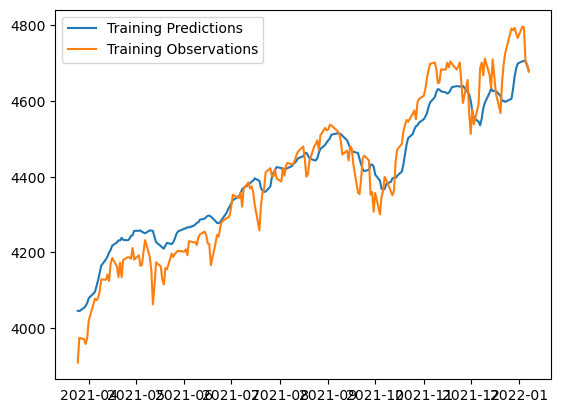

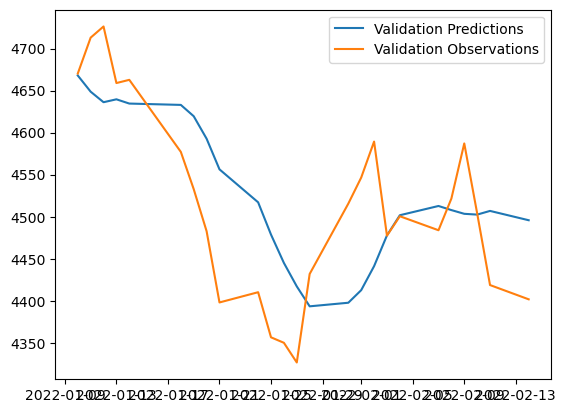

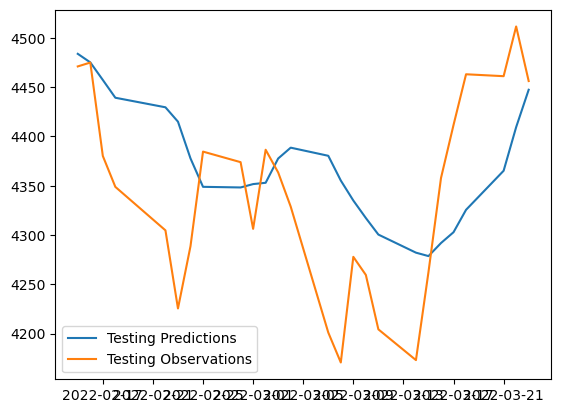

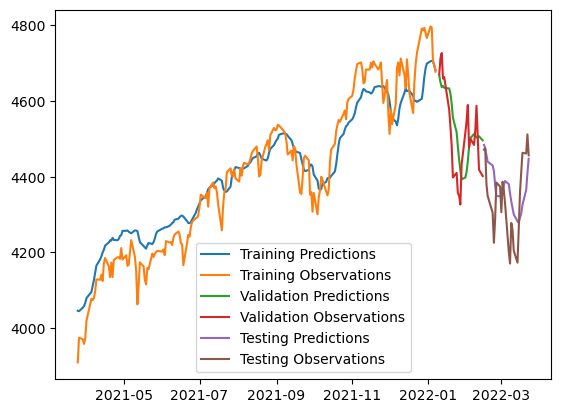

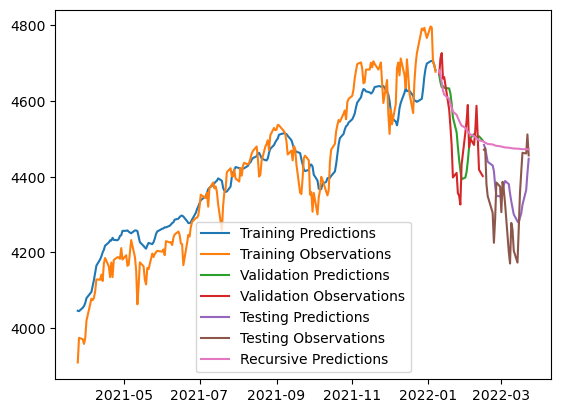

Mean Absolute Error for Training Data is: 51.296573638916016
Mean Absolute Error for Validation Data is: 71.22701263427734
Mean Absolute Error for Test Data is: 77.6005859375
Mean Absolute Error for Recursive Data is: 109.1798128365184


In [61]:
mle_analysis(df_new)